In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3287160, 828)
(3287160, 8)
validation
(389976, 828)
(389976, 8)
test
(483136, 828)
(483136, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/329 [..............................] - ETA: 7:23 - loss: 2.1431 - STD: 0.0423 - MAE: 0.2189

  4/329 [..............................] - ETA: 5s - loss: 2.1127 - STD: 0.0304 - MAE: 0.2187  

  7/329 [..............................] - ETA: 5s - loss: 2.1002 - STD: 0.0238 - MAE: 0.2187

 11/329 [>.............................] - ETA: 5s - loss: 2.0933 - STD: 0.0214 - MAE: 0.2186

 14/329 [>.............................] - ETA: 5s - loss: 2.0881 - STD: 0.0186 - MAE: 0.2186

 17/329 [>.............................] - ETA: 5s - loss: 2.0830 - STD: 0.0172 - MAE: 0.2185

 20/329 [>.............................] - ETA: 5s - loss: 2.0762 - STD: 0.0169 - MAE: 0.2183

 24/329 [=>............................] - ETA: 5s - loss: 2.0627 - STD: 0.0178 - MAE: 0.2178

 28/329 [=>............................] - ETA: 5s - loss: 2.0446 - STD: 0.0213 - MAE: 0.2170

 31/329 [=>............................] - ETA: 5s - loss: 2.0297 - STD: 0.0252 - MAE: 0.2162

 35/329 [==>...........................] - ETA: 4s - loss: 2.0097 - STD: 0.0306 - MAE: 0.2151

 39/329 [==>...........................] - ETA: 4s - loss: 1.9892 - STD: 0.0355 - MAE: 0.2139

 42/329 [==>...........................] - ETA: 4s - loss: 1.9725 - STD: 0.0388 - MAE: 0.2130

 45/329 [===>..........................] - ETA: 4s - loss: 1.9544 - STD: 0.0421 - MAE: 0.2121

 49/329 [===>..........................] - ETA: 4s - loss: 1.9298 - STD: 0.0468 - MAE: 0.2106

 52/329 [===>..........................] - ETA: 4s - loss: 1.9108 - STD: 0.0503 - MAE: 0.2095

 56/329 [====>.........................] - ETA: 4s - loss: 1.8865 - STD: 0.0551 - MAE: 0.2079

 60/329 [====>.........................] - ETA: 4s - loss: 1.8639 - STD: 0.0598 - MAE: 0.2064

 64/329 [====>.........................] - ETA: 4s - loss: 1.8428 - STD: 0.0641 - MAE: 0.2050

 68/329 [=====>........................] - ETA: 4s - loss: 1.8228 - STD: 0.0681 - MAE: 0.2036

 72/329 [=====>........................] - ETA: 4s - loss: 1.8047 - STD: 0.0718 - MAE: 0.2023

 76/329 [=====>........................] - ETA: 4s - loss: 1.7879 - STD: 0.0751 - MAE: 0.2012

 80/329 [======>.......................] - ETA: 4s - loss: 1.7718 - STD: 0.0783 - MAE: 0.2000

 84/329 [======>.......................] - ETA: 4s - loss: 1.7570 - STD: 0.0811 - MAE: 0.1990

 88/329 [=======>......................] - ETA: 3s - loss: 1.7433 - STD: 0.0837 - MAE: 0.1980

 92/329 [=======>......................] - ETA: 3s - loss: 1.7305 - STD: 0.0862 - MAE: 0.1971

 96/329 [=======>......................] - ETA: 3s - loss: 1.7185 - STD: 0.0885 - MAE: 0.1963

100/329 [========>.....................] - ETA: 3s - loss: 1.7066 - STD: 0.0907 - MAE: 0.1954

103/329 [========>.....................] - ETA: 3s - loss: 1.6979 - STD: 0.0922 - MAE: 0.1948

107/329 [========>.....................] - ETA: 3s - loss: 1.6871 - STD: 0.0941 - MAE: 0.1941

111/329 [=========>....................] - ETA: 3s - loss: 1.6767 - STD: 0.0960 - MAE: 0.1933

115/329 [=========>....................] - ETA: 3s - loss: 1.6669 - STD: 0.0978 - MAE: 0.1926

119/329 [=========>....................] - ETA: 3s - loss: 1.6573 - STD: 0.0995 - MAE: 0.1919

122/329 [==========>...................] - ETA: 3s - loss: 1.6505 - STD: 0.1008 - MAE: 0.1914

123/329 [==========>...................] - ETA: 4s - loss: 1.6490 - STD: 0.1012 - MAE: 0.1912

126/329 [==========>...................] - ETA: 4s - loss: 1.6423 - STD: 0.1023 - MAE: 0.1907

129/329 [==========>...................] - ETA: 4s - loss: 1.6357 - STD: 0.1035 - MAE: 0.1902

132/329 [===========>..................] - ETA: 4s - loss: 1.6296 - STD: 0.1046 - MAE: 0.1897

135/329 [===========>..................] - ETA: 4s - loss: 1.6232 - STD: 0.1057 - MAE: 0.1893

139/329 [===========>..................] - ETA: 4s - loss: 1.6154 - STD: 0.1071 - MAE: 0.1887

143/329 [============>.................] - ETA: 3s - loss: 1.6076 - STD: 0.1085 - MAE: 0.1880

146/329 [============>.................] - ETA: 3s - loss: 1.6018 - STD: 0.1095 - MAE: 0.1876

150/329 [============>.................] - ETA: 3s - loss: 1.5946 - STD: 0.1108 - MAE: 0.1870

153/329 [============>.................] - ETA: 3s - loss: 1.5893 - STD: 0.1118 - MAE: 0.1866

156/329 [=============>................] - ETA: 3s - loss: 1.5839 - STD: 0.1127 - MAE: 0.1862

159/329 [=============>................] - ETA: 3s - loss: 1.5787 - STD: 0.1136 - MAE: 0.1858

162/329 [=============>................] - ETA: 3s - loss: 1.5736 - STD: 0.1145 - MAE: 0.1854

165/329 [==============>...............] - ETA: 3s - loss: 1.5687 - STD: 0.1153 - MAE: 0.1850

168/329 [==============>...............] - ETA: 3s - loss: 1.5642 - STD: 0.1162 - MAE: 0.1846

172/329 [==============>...............] - ETA: 3s - loss: 1.5580 - STD: 0.1173 - MAE: 0.1841

176/329 [===============>..............] - ETA: 3s - loss: 1.5521 - STD: 0.1183 - MAE: 0.1836

180/329 [===============>..............] - ETA: 3s - loss: 1.5462 - STD: 0.1194 - MAE: 0.1831

184/329 [===============>..............] - ETA: 2s - loss: 1.5405 - STD: 0.1204 - MAE: 0.1826

188/329 [================>.............] - ETA: 2s - loss: 1.5349 - STD: 0.1214 - MAE: 0.1822

191/329 [================>.............] - ETA: 2s - loss: 1.5309 - STD: 0.1221 - MAE: 0.1818

194/329 [================>.............] - ETA: 2s - loss: 1.5270 - STD: 0.1228 - MAE: 0.1815

198/329 [=================>............] - ETA: 2s - loss: 1.5218 - STD: 0.1237 - MAE: 0.1811

201/329 [=================>............] - ETA: 2s - loss: 1.5178 - STD: 0.1244 - MAE: 0.1807

205/329 [=================>............] - ETA: 2s - loss: 1.5128 - STD: 0.1253 - MAE: 0.1803

209/329 [==================>...........] - ETA: 2s - loss: 1.5079 - STD: 0.1261 - MAE: 0.1799

212/329 [==================>...........] - ETA: 2s - loss: 1.5045 - STD: 0.1268 - MAE: 0.1796

215/329 [==================>...........] - ETA: 2s - loss: 1.5015 - STD: 0.1274 - MAE: 0.1793

218/329 [==================>...........] - ETA: 2s - loss: 1.4981 - STD: 0.1280 - MAE: 0.1790

221/329 [===================>..........] - ETA: 2s - loss: 1.4948 - STD: 0.1286 - MAE: 0.1787

224/329 [===================>..........] - ETA: 2s - loss: 1.4915 - STD: 0.1292 - MAE: 0.1784

227/329 [===================>..........] - ETA: 2s - loss: 1.4881 - STD: 0.1297 - MAE: 0.1782

230/329 [===================>..........] - ETA: 1s - loss: 1.4848 - STD: 0.1303 - MAE: 0.1779

233/329 [====================>.........] - ETA: 1s - loss: 1.4814 - STD: 0.1309 - MAE: 0.1776

236/329 [====================>.........] - ETA: 1s - loss: 1.4783 - STD: 0.1314 - MAE: 0.1773

239/329 [====================>.........] - ETA: 1s - loss: 1.4754 - STD: 0.1320 - MAE: 0.1771

243/329 [=====================>........] - ETA: 1s - loss: 1.4716 - STD: 0.1327 - MAE: 0.1767

246/329 [=====================>........] - ETA: 1s - loss: 1.4688 - STD: 0.1332 - MAE: 0.1765

250/329 [=====================>........] - ETA: 1s - loss: 1.4649 - STD: 0.1339 - MAE: 0.1761

254/329 [======================>.......] - ETA: 1s - loss: 1.4612 - STD: 0.1345 - MAE: 0.1758

258/329 [======================>.......] - ETA: 1s - loss: 1.4573 - STD: 0.1352 - MAE: 0.1754

261/329 [======================>.......] - ETA: 1s - loss: 1.4545 - STD: 0.1357 - MAE: 0.1752

264/329 [=======================>......] - ETA: 1s - loss: 1.4519 - STD: 0.1362 - MAE: 0.1750

268/329 [=======================>......] - ETA: 1s - loss: 1.4486 - STD: 0.1368 - MAE: 0.1747

272/329 [=======================>......] - ETA: 1s - loss: 1.4452 - STD: 0.1374 - MAE: 0.1744

276/329 [========================>.....] - ETA: 1s - loss: 1.4419 - STD: 0.1380 - MAE: 0.1740

279/329 [========================>.....] - ETA: 0s - loss: 1.4394 - STD: 0.1384 - MAE: 0.1738

282/329 [========================>.....] - ETA: 0s - loss: 1.4370 - STD: 0.1389 - MAE: 0.1736

285/329 [========================>.....] - ETA: 0s - loss: 1.4345 - STD: 0.1393 - MAE: 0.1734

289/329 [=========================>....] - ETA: 0s - loss: 1.4315 - STD: 0.1398 - MAE: 0.1731

292/329 [=========================>....] - ETA: 0s - loss: 1.4292 - STD: 0.1403 - MAE: 0.1729

296/329 [=========================>....] - ETA: 0s - loss: 1.4262 - STD: 0.1408 - MAE: 0.1726

300/329 [==========================>...] - ETA: 0s - loss: 1.4233 - STD: 0.1413 - MAE: 0.1724

304/329 [==========================>...] - ETA: 0s - loss: 1.4206 - STD: 0.1418 - MAE: 0.1721

307/329 [==========================>...] - ETA: 0s - loss: 1.4184 - STD: 0.1422 - MAE: 0.1719

310/329 [===========================>..] - ETA: 0s - loss: 1.4163 - STD: 0.1426 - MAE: 0.1717

313/329 [===========================>..] - ETA: 0s - loss: 1.4142 - STD: 0.1429 - MAE: 0.1715

316/329 [===========================>..] - ETA: 0s - loss: 1.4121 - STD: 0.1433 - MAE: 0.1713

319/329 [============================>.] - ETA: 0s - loss: 1.4101 - STD: 0.1437 - MAE: 0.1712

322/329 [============================>.] - ETA: 0s - loss: 1.4082 - STD: 0.1440 - MAE: 0.1710

326/329 [============================>.] - ETA: 0s - loss: 1.4054 - STD: 0.1445 - MAE: 0.1707

329/329 [==============================] - 9s 22ms/step - loss: 1.4035 - STD: 0.1449 - MAE: 0.1705 - val_loss: 1.2240 - val_STD: 0.1824 - val_MAE: 0.1518


Epoch 2/10000


  1/329 [..............................] - ETA: 15s - loss: 1.1735 - STD: 0.1825 - MAE: 0.1499

  4/329 [..............................] - ETA: 6s - loss: 1.1752 - STD: 0.1826 - MAE: 0.1501 

  8/329 [..............................] - ETA: 5s - loss: 1.1880 - STD: 0.1827 - MAE: 0.1506

 11/329 [>.............................] - ETA: 5s - loss: 1.1927 - STD: 0.1828 - MAE: 0.1508

 15/329 [>.............................] - ETA: 5s - loss: 1.1924 - STD: 0.1829 - MAE: 0.1508

 18/329 [>.............................] - ETA: 5s - loss: 1.1922 - STD: 0.1829 - MAE: 0.1508

 21/329 [>.............................] - ETA: 5s - loss: 1.1899 - STD: 0.1828 - MAE: 0.1507

 24/329 [=>............................] - ETA: 5s - loss: 1.1877 - STD: 0.1829 - MAE: 0.1506

 27/329 [=>............................] - ETA: 5s - loss: 1.1847 - STD: 0.1830 - MAE: 0.1504

 30/329 [=>............................] - ETA: 5s - loss: 1.1836 - STD: 0.1831 - MAE: 0.1504

 34/329 [==>...........................] - ETA: 5s - loss: 1.1818 - STD: 0.1834 - MAE: 0.1502

 37/329 [==>...........................] - ETA: 5s - loss: 1.1802 - STD: 0.1835 - MAE: 0.1501

 40/329 [==>...........................] - ETA: 5s - loss: 1.1793 - STD: 0.1836 - MAE: 0.1500

 44/329 [===>..........................] - ETA: 4s - loss: 1.1779 - STD: 0.1837 - MAE: 0.1499

 47/329 [===>..........................] - ETA: 4s - loss: 1.1795 - STD: 0.1839 - MAE: 0.1499

 50/329 [===>..........................] - ETA: 4s - loss: 1.1793 - STD: 0.1840 - MAE: 0.1499

 53/329 [===>..........................] - ETA: 4s - loss: 1.1795 - STD: 0.1841 - MAE: 0.1498

 56/329 [====>.........................] - ETA: 4s - loss: 1.1796 - STD: 0.1842 - MAE: 0.1498

 60/329 [====>.........................] - ETA: 4s - loss: 1.1798 - STD: 0.1843 - MAE: 0.1498

 63/329 [====>.........................] - ETA: 4s - loss: 1.1794 - STD: 0.1844 - MAE: 0.1497

 66/329 [=====>........................] - ETA: 4s - loss: 1.1788 - STD: 0.1844 - MAE: 0.1497

 69/329 [=====>........................] - ETA: 4s - loss: 1.1781 - STD: 0.1845 - MAE: 0.1496

 72/329 [=====>........................] - ETA: 4s - loss: 1.1776 - STD: 0.1846 - MAE: 0.1495

 75/329 [=====>........................] - ETA: 4s - loss: 1.1765 - STD: 0.1846 - MAE: 0.1495

 79/329 [======>.......................] - ETA: 4s - loss: 1.1755 - STD: 0.1847 - MAE: 0.1494

 83/329 [======>.......................] - ETA: 4s - loss: 1.1743 - STD: 0.1848 - MAE: 0.1493

 86/329 [======>.......................] - ETA: 4s - loss: 1.1737 - STD: 0.1849 - MAE: 0.1492

 89/329 [=======>......................] - ETA: 4s - loss: 1.1732 - STD: 0.1849 - MAE: 0.1492

 93/329 [=======>......................] - ETA: 4s - loss: 1.1728 - STD: 0.1850 - MAE: 0.1491

 96/329 [=======>......................] - ETA: 4s - loss: 1.1723 - STD: 0.1851 - MAE: 0.1491

100/329 [========>.....................] - ETA: 3s - loss: 1.1712 - STD: 0.1852 - MAE: 0.1490

103/329 [========>.....................] - ETA: 3s - loss: 1.1704 - STD: 0.1853 - MAE: 0.1489

106/329 [========>.....................] - ETA: 3s - loss: 1.1695 - STD: 0.1854 - MAE: 0.1488

110/329 [=========>....................] - ETA: 3s - loss: 1.1687 - STD: 0.1855 - MAE: 0.1488

113/329 [=========>....................] - ETA: 3s - loss: 1.1681 - STD: 0.1856 - MAE: 0.1487

116/329 [=========>....................] - ETA: 3s - loss: 1.1680 - STD: 0.1857 - MAE: 0.1486

119/329 [=========>....................] - ETA: 3s - loss: 1.1677 - STD: 0.1857 - MAE: 0.1486

122/329 [==========>...................] - ETA: 3s - loss: 1.1676 - STD: 0.1858 - MAE: 0.1486

125/329 [==========>...................] - ETA: 3s - loss: 1.1671 - STD: 0.1858 - MAE: 0.1485

129/329 [==========>...................] - ETA: 3s - loss: 1.1665 - STD: 0.1859 - MAE: 0.1485

132/329 [===========>..................] - ETA: 3s - loss: 1.1663 - STD: 0.1860 - MAE: 0.1484

136/329 [===========>..................] - ETA: 3s - loss: 1.1657 - STD: 0.1861 - MAE: 0.1484

140/329 [===========>..................] - ETA: 3s - loss: 1.1648 - STD: 0.1862 - MAE: 0.1483

144/329 [============>.................] - ETA: 3s - loss: 1.1641 - STD: 0.1863 - MAE: 0.1482

147/329 [============>.................] - ETA: 3s - loss: 1.1637 - STD: 0.1864 - MAE: 0.1482

151/329 [============>.................] - ETA: 3s - loss: 1.1631 - STD: 0.1865 - MAE: 0.1481

154/329 [=============>................] - ETA: 2s - loss: 1.1624 - STD: 0.1866 - MAE: 0.1480

157/329 [=============>................] - ETA: 2s - loss: 1.1622 - STD: 0.1867 - MAE: 0.1480

161/329 [=============>................] - ETA: 2s - loss: 1.1622 - STD: 0.1867 - MAE: 0.1480

165/329 [==============>...............] - ETA: 2s - loss: 1.1621 - STD: 0.1868 - MAE: 0.1479

168/329 [==============>...............] - ETA: 2s - loss: 1.1618 - STD: 0.1869 - MAE: 0.1479

171/329 [==============>...............] - ETA: 2s - loss: 1.1615 - STD: 0.1869 - MAE: 0.1479

175/329 [==============>...............] - ETA: 2s - loss: 1.1611 - STD: 0.1870 - MAE: 0.1478

178/329 [===============>..............] - ETA: 2s - loss: 1.1608 - STD: 0.1871 - MAE: 0.1478

181/329 [===============>..............] - ETA: 2s - loss: 1.1603 - STD: 0.1871 - MAE: 0.1477

184/329 [===============>..............] - ETA: 2s - loss: 1.1598 - STD: 0.1872 - MAE: 0.1477

187/329 [================>.............] - ETA: 2s - loss: 1.1593 - STD: 0.1872 - MAE: 0.1476

190/329 [================>.............] - ETA: 2s - loss: 1.1588 - STD: 0.1873 - MAE: 0.1476

193/329 [================>.............] - ETA: 2s - loss: 1.1583 - STD: 0.1873 - MAE: 0.1475

196/329 [================>.............] - ETA: 2s - loss: 1.1576 - STD: 0.1874 - MAE: 0.1475

200/329 [=================>............] - ETA: 2s - loss: 1.1567 - STD: 0.1875 - MAE: 0.1474

203/329 [=================>............] - ETA: 2s - loss: 1.1561 - STD: 0.1876 - MAE: 0.1473

206/329 [=================>............] - ETA: 2s - loss: 1.1554 - STD: 0.1877 - MAE: 0.1473

209/329 [==================>...........] - ETA: 2s - loss: 1.1549 - STD: 0.1877 - MAE: 0.1472

212/329 [==================>...........] - ETA: 2s - loss: 1.1542 - STD: 0.1878 - MAE: 0.1472

216/329 [==================>...........] - ETA: 1s - loss: 1.1535 - STD: 0.1879 - MAE: 0.1471

220/329 [===================>..........] - ETA: 1s - loss: 1.1529 - STD: 0.1880 - MAE: 0.1470

223/329 [===================>..........] - ETA: 1s - loss: 1.1522 - STD: 0.1880 - MAE: 0.1470

226/329 [===================>..........] - ETA: 1s - loss: 1.1517 - STD: 0.1881 - MAE: 0.1469

229/329 [===================>..........] - ETA: 1s - loss: 1.1513 - STD: 0.1882 - MAE: 0.1469

232/329 [====================>.........] - ETA: 1s - loss: 1.1508 - STD: 0.1882 - MAE: 0.1468

235/329 [====================>.........] - ETA: 1s - loss: 1.1503 - STD: 0.1883 - MAE: 0.1468

238/329 [====================>.........] - ETA: 1s - loss: 1.1497 - STD: 0.1884 - MAE: 0.1467

241/329 [====================>.........] - ETA: 1s - loss: 1.1493 - STD: 0.1884 - MAE: 0.1467

244/329 [=====================>........] - ETA: 1s - loss: 1.1488 - STD: 0.1885 - MAE: 0.1466

247/329 [=====================>........] - ETA: 1s - loss: 1.1485 - STD: 0.1885 - MAE: 0.1466

250/329 [=====================>........] - ETA: 1s - loss: 1.1480 - STD: 0.1886 - MAE: 0.1465

253/329 [======================>.......] - ETA: 1s - loss: 1.1475 - STD: 0.1887 - MAE: 0.1465

256/329 [======================>.......] - ETA: 1s - loss: 1.1471 - STD: 0.1887 - MAE: 0.1464

259/329 [======================>.......] - ETA: 1s - loss: 1.1469 - STD: 0.1888 - MAE: 0.1464

262/329 [======================>.......] - ETA: 1s - loss: 1.1465 - STD: 0.1889 - MAE: 0.1464

265/329 [=======================>......] - ETA: 1s - loss: 1.1463 - STD: 0.1889 - MAE: 0.1463

268/329 [=======================>......] - ETA: 1s - loss: 1.1457 - STD: 0.1890 - MAE: 0.1463

272/329 [=======================>......] - ETA: 0s - loss: 1.1452 - STD: 0.1891 - MAE: 0.1462

275/329 [========================>.....] - ETA: 0s - loss: 1.1447 - STD: 0.1891 - MAE: 0.1462

279/329 [========================>.....] - ETA: 0s - loss: 1.1441 - STD: 0.1892 - MAE: 0.1461

282/329 [========================>.....] - ETA: 0s - loss: 1.1435 - STD: 0.1892 - MAE: 0.1461

286/329 [=========================>....] - ETA: 0s - loss: 1.1429 - STD: 0.1893 - MAE: 0.1460

289/329 [=========================>....] - ETA: 0s - loss: 1.1425 - STD: 0.1894 - MAE: 0.1460

292/329 [=========================>....] - ETA: 0s - loss: 1.1420 - STD: 0.1894 - MAE: 0.1459

295/329 [=========================>....] - ETA: 0s - loss: 1.1417 - STD: 0.1895 - MAE: 0.1459

298/329 [==========================>...] - ETA: 0s - loss: 1.1412 - STD: 0.1895 - MAE: 0.1458

301/329 [==========================>...] - ETA: 0s - loss: 1.1407 - STD: 0.1896 - MAE: 0.1458

304/329 [==========================>...] - ETA: 0s - loss: 1.1402 - STD: 0.1896 - MAE: 0.1458

307/329 [==========================>...] - ETA: 0s - loss: 1.1398 - STD: 0.1897 - MAE: 0.1457

311/329 [===========================>..] - ETA: 0s - loss: 1.1396 - STD: 0.1898 - MAE: 0.1457

314/329 [===========================>..] - ETA: 0s - loss: 1.1391 - STD: 0.1899 - MAE: 0.1456

317/329 [===========================>..] - ETA: 0s - loss: 1.1389 - STD: 0.1899 - MAE: 0.1456

320/329 [============================>.] - ETA: 0s - loss: 1.1387 - STD: 0.1900 - MAE: 0.1456

323/329 [============================>.] - ETA: 0s - loss: 1.1384 - STD: 0.1900 - MAE: 0.1455

326/329 [============================>.] - ETA: 0s - loss: 1.1380 - STD: 0.1900 - MAE: 0.1455

329/329 [==============================] - 6s 19ms/step - loss: 1.1375 - STD: 0.1901 - MAE: 0.1454 - val_loss: 1.1401 - val_STD: 0.1970 - val_MAE: 0.1418


Epoch 3/10000


  1/329 [..............................] - ETA: 15s - loss: 1.0770 - STD: 0.1974 - MAE: 0.1396

  4/329 [..............................] - ETA: 5s - loss: 1.0782 - STD: 0.1964 - MAE: 0.1399 

  7/329 [..............................] - ETA: 5s - loss: 1.0794 - STD: 0.1960 - MAE: 0.1401

 11/329 [>.............................] - ETA: 5s - loss: 1.0816 - STD: 0.1959 - MAE: 0.1403

 14/329 [>.............................] - ETA: 5s - loss: 1.0802 - STD: 0.1960 - MAE: 0.1402

 17/329 [>.............................] - ETA: 5s - loss: 1.0819 - STD: 0.1958 - MAE: 0.1404

 20/329 [>.............................] - ETA: 5s - loss: 1.0815 - STD: 0.1960 - MAE: 0.1403

 23/329 [=>............................] - ETA: 5s - loss: 1.0809 - STD: 0.1962 - MAE: 0.1402

 26/329 [=>............................] - ETA: 5s - loss: 1.0807 - STD: 0.1962 - MAE: 0.1402

 29/329 [=>............................] - ETA: 5s - loss: 1.0810 - STD: 0.1963 - MAE: 0.1402

 32/329 [=>............................] - ETA: 5s - loss: 1.0801 - STD: 0.1963 - MAE: 0.1401

 35/329 [==>...........................] - ETA: 5s - loss: 1.0797 - STD: 0.1963 - MAE: 0.1401

 39/329 [==>...........................] - ETA: 4s - loss: 1.0805 - STD: 0.1964 - MAE: 0.1401

 42/329 [==>...........................] - ETA: 4s - loss: 1.0809 - STD: 0.1965 - MAE: 0.1401

 45/329 [===>..........................] - ETA: 4s - loss: 1.0798 - STD: 0.1967 - MAE: 0.1400

 49/329 [===>..........................] - ETA: 4s - loss: 1.0797 - STD: 0.1968 - MAE: 0.1399

 52/329 [===>..........................] - ETA: 4s - loss: 1.0791 - STD: 0.1969 - MAE: 0.1398

 56/329 [====>.........................] - ETA: 4s - loss: 1.0783 - STD: 0.1970 - MAE: 0.1397

 60/329 [====>.........................] - ETA: 4s - loss: 1.0778 - STD: 0.1971 - MAE: 0.1397

 63/329 [====>.........................] - ETA: 4s - loss: 1.0771 - STD: 0.1972 - MAE: 0.1396

 66/329 [=====>........................] - ETA: 4s - loss: 1.0764 - STD: 0.1972 - MAE: 0.1396

 70/329 [=====>........................] - ETA: 4s - loss: 1.0758 - STD: 0.1973 - MAE: 0.1395

 73/329 [=====>........................] - ETA: 4s - loss: 1.0754 - STD: 0.1974 - MAE: 0.1394

 76/329 [=====>........................] - ETA: 4s - loss: 1.0752 - STD: 0.1974 - MAE: 0.1394

 79/329 [======>.......................] - ETA: 4s - loss: 1.0753 - STD: 0.1974 - MAE: 0.1394

 83/329 [======>.......................] - ETA: 4s - loss: 1.0771 - STD: 0.1975 - MAE: 0.1395

 86/329 [======>.......................] - ETA: 4s - loss: 1.0773 - STD: 0.1976 - MAE: 0.1395

 89/329 [=======>......................] - ETA: 4s - loss: 1.0774 - STD: 0.1976 - MAE: 0.1395

 92/329 [=======>......................] - ETA: 4s - loss: 1.0769 - STD: 0.1976 - MAE: 0.1394

 95/329 [=======>......................] - ETA: 3s - loss: 1.0766 - STD: 0.1977 - MAE: 0.1394

 99/329 [========>.....................] - ETA: 3s - loss: 1.0764 - STD: 0.1977 - MAE: 0.1394

102/329 [========>.....................] - ETA: 3s - loss: 1.0758 - STD: 0.1977 - MAE: 0.1393

105/329 [========>.....................] - ETA: 3s - loss: 1.0755 - STD: 0.1977 - MAE: 0.1393

108/329 [========>.....................] - ETA: 3s - loss: 1.0751 - STD: 0.1977 - MAE: 0.1393

111/329 [=========>....................] - ETA: 3s - loss: 1.0748 - STD: 0.1978 - MAE: 0.1392

114/329 [=========>....................] - ETA: 3s - loss: 1.0743 - STD: 0.1978 - MAE: 0.1392

118/329 [=========>....................] - ETA: 3s - loss: 1.0738 - STD: 0.1978 - MAE: 0.1392

121/329 [==========>...................] - ETA: 3s - loss: 1.0736 - STD: 0.1979 - MAE: 0.1391

124/329 [==========>...................] - ETA: 3s - loss: 1.0732 - STD: 0.1979 - MAE: 0.1391

127/329 [==========>...................] - ETA: 3s - loss: 1.0734 - STD: 0.1980 - MAE: 0.1391

130/329 [==========>...................] - ETA: 3s - loss: 1.0736 - STD: 0.1980 - MAE: 0.1391

133/329 [===========>..................] - ETA: 3s - loss: 1.0734 - STD: 0.1981 - MAE: 0.1390

136/329 [===========>..................] - ETA: 3s - loss: 1.0735 - STD: 0.1981 - MAE: 0.1390

139/329 [===========>..................] - ETA: 3s - loss: 1.0735 - STD: 0.1981 - MAE: 0.1390

142/329 [===========>..................] - ETA: 3s - loss: 1.0734 - STD: 0.1981 - MAE: 0.1390

145/329 [============>.................] - ETA: 3s - loss: 1.0731 - STD: 0.1981 - MAE: 0.1390

149/329 [============>.................] - ETA: 3s - loss: 1.0727 - STD: 0.1982 - MAE: 0.1389

152/329 [============>.................] - ETA: 3s - loss: 1.0720 - STD: 0.1982 - MAE: 0.1389

155/329 [=============>................] - ETA: 2s - loss: 1.0716 - STD: 0.1983 - MAE: 0.1388

159/329 [=============>................] - ETA: 2s - loss: 1.0712 - STD: 0.1983 - MAE: 0.1388

163/329 [=============>................] - ETA: 2s - loss: 1.0706 - STD: 0.1984 - MAE: 0.1388

167/329 [==============>...............] - ETA: 2s - loss: 1.0698 - STD: 0.1984 - MAE: 0.1387

170/329 [==============>...............] - ETA: 2s - loss: 1.0697 - STD: 0.1985 - MAE: 0.1387

173/329 [==============>...............] - ETA: 2s - loss: 1.0693 - STD: 0.1985 - MAE: 0.1386

177/329 [===============>..............] - ETA: 2s - loss: 1.0686 - STD: 0.1986 - MAE: 0.1386

180/329 [===============>..............] - ETA: 2s - loss: 1.0682 - STD: 0.1987 - MAE: 0.1385

184/329 [===============>..............] - ETA: 2s - loss: 1.0675 - STD: 0.1987 - MAE: 0.1384

187/329 [================>.............] - ETA: 2s - loss: 1.0673 - STD: 0.1988 - MAE: 0.1384

190/329 [================>.............] - ETA: 2s - loss: 1.0671 - STD: 0.1988 - MAE: 0.1384

193/329 [================>.............] - ETA: 2s - loss: 1.0669 - STD: 0.1988 - MAE: 0.1384

196/329 [================>.............] - ETA: 2s - loss: 1.0667 - STD: 0.1989 - MAE: 0.1383

200/329 [=================>............] - ETA: 2s - loss: 1.0661 - STD: 0.1989 - MAE: 0.1383

203/329 [=================>............] - ETA: 2s - loss: 1.0656 - STD: 0.1990 - MAE: 0.1382

206/329 [=================>............] - ETA: 2s - loss: 1.0651 - STD: 0.1990 - MAE: 0.1382

209/329 [==================>...........] - ETA: 2s - loss: 1.0647 - STD: 0.1991 - MAE: 0.1381

212/329 [==================>...........] - ETA: 1s - loss: 1.0644 - STD: 0.1991 - MAE: 0.1381

216/329 [==================>...........] - ETA: 1s - loss: 1.0640 - STD: 0.1992 - MAE: 0.1381

219/329 [==================>...........] - ETA: 1s - loss: 1.0640 - STD: 0.1993 - MAE: 0.1380

222/329 [===================>..........] - ETA: 1s - loss: 1.0637 - STD: 0.1993 - MAE: 0.1380

225/329 [===================>..........] - ETA: 1s - loss: 1.0635 - STD: 0.1993 - MAE: 0.1380

228/329 [===================>..........] - ETA: 1s - loss: 1.0633 - STD: 0.1994 - MAE: 0.1380

232/329 [====================>.........] - ETA: 1s - loss: 1.0630 - STD: 0.1994 - MAE: 0.1379

235/329 [====================>.........] - ETA: 1s - loss: 1.0626 - STD: 0.1994 - MAE: 0.1379

238/329 [====================>.........] - ETA: 1s - loss: 1.0624 - STD: 0.1995 - MAE: 0.1379

241/329 [====================>.........] - ETA: 1s - loss: 1.0624 - STD: 0.1995 - MAE: 0.1378

244/329 [=====================>........] - ETA: 1s - loss: 1.0625 - STD: 0.1995 - MAE: 0.1378

247/329 [=====================>........] - ETA: 1s - loss: 1.0624 - STD: 0.1996 - MAE: 0.1378

250/329 [=====================>........] - ETA: 1s - loss: 1.0625 - STD: 0.1996 - MAE: 0.1378

254/329 [======================>.......] - ETA: 1s - loss: 1.0622 - STD: 0.1996 - MAE: 0.1378

257/329 [======================>.......] - ETA: 1s - loss: 1.0620 - STD: 0.1997 - MAE: 0.1377

260/329 [======================>.......] - ETA: 1s - loss: 1.0616 - STD: 0.1997 - MAE: 0.1377

263/329 [======================>.......] - ETA: 1s - loss: 1.0611 - STD: 0.1997 - MAE: 0.1377

267/329 [=======================>......] - ETA: 1s - loss: 1.0606 - STD: 0.1998 - MAE: 0.1376

270/329 [=======================>......] - ETA: 1s - loss: 1.0603 - STD: 0.1998 - MAE: 0.1376

273/329 [=======================>......] - ETA: 0s - loss: 1.0599 - STD: 0.1999 - MAE: 0.1375

276/329 [========================>.....] - ETA: 0s - loss: 1.0596 - STD: 0.1999 - MAE: 0.1375

280/329 [========================>.....] - ETA: 0s - loss: 1.0591 - STD: 0.2000 - MAE: 0.1375

284/329 [========================>.....] - ETA: 0s - loss: 1.0587 - STD: 0.2000 - MAE: 0.1374

287/329 [=========================>....] - ETA: 0s - loss: 1.0582 - STD: 0.2001 - MAE: 0.1374

290/329 [=========================>....] - ETA: 0s - loss: 1.0578 - STD: 0.2001 - MAE: 0.1373

294/329 [=========================>....] - ETA: 0s - loss: 1.0572 - STD: 0.2002 - MAE: 0.1373

297/329 [==========================>...] - ETA: 0s - loss: 1.0568 - STD: 0.2002 - MAE: 0.1372

301/329 [==========================>...] - ETA: 0s - loss: 1.0561 - STD: 0.2003 - MAE: 0.1372

305/329 [==========================>...] - ETA: 0s - loss: 1.0555 - STD: 0.2003 - MAE: 0.1371

309/329 [===========================>..] - ETA: 0s - loss: 1.0549 - STD: 0.2004 - MAE: 0.1371

312/329 [===========================>..] - ETA: 0s - loss: 1.0544 - STD: 0.2005 - MAE: 0.1370

315/329 [===========================>..] - ETA: 0s - loss: 1.0541 - STD: 0.2005 - MAE: 0.1370

319/329 [============================>.] - ETA: 0s - loss: 1.0536 - STD: 0.2006 - MAE: 0.1369

323/329 [============================>.] - ETA: 0s - loss: 1.0532 - STD: 0.2007 - MAE: 0.1369

326/329 [============================>.] - ETA: 0s - loss: 1.0528 - STD: 0.2007 - MAE: 0.1368

329/329 [==============================] - 6s 19ms/step - loss: 1.0526 - STD: 0.2008 - MAE: 0.1368 - val_loss: 1.1739 - val_STD: 0.2072 - val_MAE: 0.1412


Epoch 4/10000


  1/329 [..............................] - ETA: 16s - loss: 1.0775 - STD: 0.2079 - MAE: 0.1358

  4/329 [..............................] - ETA: 5s - loss: 1.0484 - STD: 0.2055 - MAE: 0.1348 

  8/329 [..............................] - ETA: 5s - loss: 1.0438 - STD: 0.2059 - MAE: 0.1343

 12/329 [>.............................] - ETA: 5s - loss: 1.0397 - STD: 0.2058 - MAE: 0.1341

 15/329 [>.............................] - ETA: 5s - loss: 1.0334 - STD: 0.2056 - MAE: 0.1338

 18/329 [>.............................] - ETA: 5s - loss: 1.0291 - STD: 0.2054 - MAE: 0.1336

 21/329 [>.............................] - ETA: 5s - loss: 1.0267 - STD: 0.2053 - MAE: 0.1336

 24/329 [=>............................] - ETA: 5s - loss: 1.0247 - STD: 0.2053 - MAE: 0.1334

 27/329 [=>............................] - ETA: 5s - loss: 1.0245 - STD: 0.2054 - MAE: 0.1334

 31/329 [=>............................] - ETA: 5s - loss: 1.0238 - STD: 0.2055 - MAE: 0.1333

 34/329 [==>...........................] - ETA: 5s - loss: 1.0233 - STD: 0.2056 - MAE: 0.1333

 37/329 [==>...........................] - ETA: 5s - loss: 1.0244 - STD: 0.2056 - MAE: 0.1333

 40/329 [==>...........................] - ETA: 5s - loss: 1.0245 - STD: 0.2056 - MAE: 0.1333

 43/329 [==>...........................] - ETA: 4s - loss: 1.0246 - STD: 0.2056 - MAE: 0.1333

 46/329 [===>..........................] - ETA: 4s - loss: 1.0236 - STD: 0.2056 - MAE: 0.1332

 49/329 [===>..........................] - ETA: 4s - loss: 1.0229 - STD: 0.2057 - MAE: 0.1332

 52/329 [===>..........................] - ETA: 4s - loss: 1.0226 - STD: 0.2058 - MAE: 0.1331

 55/329 [====>.........................] - ETA: 4s - loss: 1.0220 - STD: 0.2058 - MAE: 0.1331

 59/329 [====>.........................] - ETA: 4s - loss: 1.0223 - STD: 0.2059 - MAE: 0.1331

 63/329 [====>.........................] - ETA: 4s - loss: 1.0228 - STD: 0.2059 - MAE: 0.1331

 66/329 [=====>........................] - ETA: 4s - loss: 1.0222 - STD: 0.2060 - MAE: 0.1330

 70/329 [=====>........................] - ETA: 4s - loss: 1.0215 - STD: 0.2060 - MAE: 0.1330

 73/329 [=====>........................] - ETA: 4s - loss: 1.0210 - STD: 0.2060 - MAE: 0.1329

 76/329 [=====>........................] - ETA: 4s - loss: 1.0205 - STD: 0.2060 - MAE: 0.1329

 80/329 [======>.......................] - ETA: 4s - loss: 1.0195 - STD: 0.2060 - MAE: 0.1328

 84/329 [======>.......................] - ETA: 4s - loss: 1.0188 - STD: 0.2061 - MAE: 0.1328

 87/329 [======>.......................] - ETA: 4s - loss: 1.0186 - STD: 0.2061 - MAE: 0.1328

 90/329 [=======>......................] - ETA: 4s - loss: 1.0180 - STD: 0.2062 - MAE: 0.1327

 93/329 [=======>......................] - ETA: 4s - loss: 1.0172 - STD: 0.2062 - MAE: 0.1326

 96/329 [=======>......................] - ETA: 4s - loss: 1.0163 - STD: 0.2063 - MAE: 0.1325

100/329 [========>.....................] - ETA: 3s - loss: 1.0156 - STD: 0.2064 - MAE: 0.1325

103/329 [========>.....................] - ETA: 3s - loss: 1.0150 - STD: 0.2064 - MAE: 0.1324

106/329 [========>.....................] - ETA: 3s - loss: 1.0144 - STD: 0.2064 - MAE: 0.1324

109/329 [========>.....................] - ETA: 3s - loss: 1.0138 - STD: 0.2065 - MAE: 0.1323

112/329 [=========>....................] - ETA: 3s - loss: 1.0132 - STD: 0.2065 - MAE: 0.1322

116/329 [=========>....................] - ETA: 3s - loss: 1.0127 - STD: 0.2066 - MAE: 0.1322

120/329 [=========>....................] - ETA: 3s - loss: 1.0118 - STD: 0.2067 - MAE: 0.1321

123/329 [==========>...................] - ETA: 3s - loss: 1.0114 - STD: 0.2067 - MAE: 0.1321

126/329 [==========>...................] - ETA: 3s - loss: 1.0109 - STD: 0.2068 - MAE: 0.1320

130/329 [==========>...................] - ETA: 3s - loss: 1.0102 - STD: 0.2068 - MAE: 0.1320

134/329 [===========>..................] - ETA: 3s - loss: 1.0099 - STD: 0.2069 - MAE: 0.1319

137/329 [===========>..................] - ETA: 3s - loss: 1.0096 - STD: 0.2069 - MAE: 0.1319

140/329 [===========>..................] - ETA: 3s - loss: 1.0090 - STD: 0.2069 - MAE: 0.1318

144/329 [============>.................] - ETA: 3s - loss: 1.0090 - STD: 0.2070 - MAE: 0.1318

148/329 [============>.................] - ETA: 3s - loss: 1.0087 - STD: 0.2071 - MAE: 0.1318

151/329 [============>.................] - ETA: 3s - loss: 1.0088 - STD: 0.2071 - MAE: 0.1317

154/329 [=============>................] - ETA: 2s - loss: 1.0087 - STD: 0.2072 - MAE: 0.1317

158/329 [=============>................] - ETA: 2s - loss: 1.0086 - STD: 0.2072 - MAE: 0.1317

161/329 [=============>................] - ETA: 2s - loss: 1.0082 - STD: 0.2072 - MAE: 0.1317

164/329 [=============>................] - ETA: 2s - loss: 1.0077 - STD: 0.2073 - MAE: 0.1316

167/329 [==============>...............] - ETA: 2s - loss: 1.0070 - STD: 0.2073 - MAE: 0.1316

170/329 [==============>...............] - ETA: 2s - loss: 1.0065 - STD: 0.2073 - MAE: 0.1315

173/329 [==============>...............] - ETA: 2s - loss: 1.0063 - STD: 0.2074 - MAE: 0.1315

176/329 [===============>..............] - ETA: 2s - loss: 1.0059 - STD: 0.2074 - MAE: 0.1314

179/329 [===============>..............] - ETA: 2s - loss: 1.0056 - STD: 0.2075 - MAE: 0.1314

183/329 [===============>..............] - ETA: 2s - loss: 1.0051 - STD: 0.2075 - MAE: 0.1313

187/329 [================>.............] - ETA: 2s - loss: 1.0045 - STD: 0.2076 - MAE: 0.1313

191/329 [================>.............] - ETA: 2s - loss: 1.0040 - STD: 0.2076 - MAE: 0.1312

194/329 [================>.............] - ETA: 2s - loss: 1.0038 - STD: 0.2077 - MAE: 0.1312

198/329 [=================>............] - ETA: 2s - loss: 1.0034 - STD: 0.2077 - MAE: 0.1312

201/329 [=================>............] - ETA: 2s - loss: 1.0034 - STD: 0.2078 - MAE: 0.1311

204/329 [=================>............] - ETA: 2s - loss: 1.0033 - STD: 0.2078 - MAE: 0.1311

208/329 [=================>............] - ETA: 2s - loss: 1.0034 - STD: 0.2079 - MAE: 0.1311

211/329 [==================>...........] - ETA: 2s - loss: 1.0032 - STD: 0.2079 - MAE: 0.1311

214/329 [==================>...........] - ETA: 1s - loss: 1.0028 - STD: 0.2079 - MAE: 0.1310

217/329 [==================>...........] - ETA: 1s - loss: 1.0026 - STD: 0.2080 - MAE: 0.1310

221/329 [===================>..........] - ETA: 1s - loss: 1.0022 - STD: 0.2080 - MAE: 0.1310

225/329 [===================>..........] - ETA: 1s - loss: 1.0015 - STD: 0.2081 - MAE: 0.1309

229/329 [===================>..........] - ETA: 1s - loss: 1.0010 - STD: 0.2081 - MAE: 0.1309

232/329 [====================>.........] - ETA: 1s - loss: 1.0007 - STD: 0.2081 - MAE: 0.1308

235/329 [====================>.........] - ETA: 1s - loss: 1.0005 - STD: 0.2082 - MAE: 0.1308

239/329 [====================>.........] - ETA: 1s - loss: 0.9999 - STD: 0.2082 - MAE: 0.1308

243/329 [=====================>........] - ETA: 1s - loss: 0.9996 - STD: 0.2083 - MAE: 0.1307

246/329 [=====================>........] - ETA: 1s - loss: 0.9992 - STD: 0.2083 - MAE: 0.1307

249/329 [=====================>........] - ETA: 1s - loss: 0.9990 - STD: 0.2084 - MAE: 0.1306

252/329 [=====================>........] - ETA: 1s - loss: 0.9987 - STD: 0.2084 - MAE: 0.1306

255/329 [======================>.......] - ETA: 1s - loss: 0.9984 - STD: 0.2084 - MAE: 0.1306

258/329 [======================>.......] - ETA: 1s - loss: 0.9983 - STD: 0.2085 - MAE: 0.1306

262/329 [======================>.......] - ETA: 1s - loss: 0.9980 - STD: 0.2085 - MAE: 0.1305

265/329 [=======================>......] - ETA: 1s - loss: 0.9980 - STD: 0.2085 - MAE: 0.1305

268/329 [=======================>......] - ETA: 1s - loss: 0.9977 - STD: 0.2086 - MAE: 0.1305

271/329 [=======================>......] - ETA: 0s - loss: 0.9978 - STD: 0.2086 - MAE: 0.1305

275/329 [========================>.....] - ETA: 0s - loss: 0.9976 - STD: 0.2087 - MAE: 0.1304

279/329 [========================>.....] - ETA: 0s - loss: 0.9976 - STD: 0.2087 - MAE: 0.1304

282/329 [========================>.....] - ETA: 0s - loss: 0.9973 - STD: 0.2087 - MAE: 0.1304

285/329 [========================>.....] - ETA: 0s - loss: 0.9971 - STD: 0.2087 - MAE: 0.1304

288/329 [=========================>....] - ETA: 0s - loss: 0.9968 - STD: 0.2088 - MAE: 0.1303

291/329 [=========================>....] - ETA: 0s - loss: 0.9964 - STD: 0.2088 - MAE: 0.1303

295/329 [=========================>....] - ETA: 0s - loss: 0.9960 - STD: 0.2089 - MAE: 0.1303

298/329 [==========================>...] - ETA: 0s - loss: 0.9956 - STD: 0.2089 - MAE: 0.1302

301/329 [==========================>...] - ETA: 0s - loss: 0.9953 - STD: 0.2089 - MAE: 0.1302

304/329 [==========================>...] - ETA: 0s - loss: 0.9951 - STD: 0.2090 - MAE: 0.1302

307/329 [==========================>...] - ETA: 0s - loss: 0.9947 - STD: 0.2090 - MAE: 0.1301

310/329 [===========================>..] - ETA: 0s - loss: 0.9946 - STD: 0.2090 - MAE: 0.1301

313/329 [===========================>..] - ETA: 0s - loss: 0.9944 - STD: 0.2091 - MAE: 0.1301

316/329 [===========================>..] - ETA: 0s - loss: 0.9943 - STD: 0.2091 - MAE: 0.1301

319/329 [============================>.] - ETA: 0s - loss: 0.9943 - STD: 0.2091 - MAE: 0.1300

322/329 [============================>.] - ETA: 0s - loss: 0.9940 - STD: 0.2092 - MAE: 0.1300

325/329 [============================>.] - ETA: 0s - loss: 0.9937 - STD: 0.2092 - MAE: 0.1300

329/329 [==============================] - ETA: 0s - loss: 0.9934 - STD: 0.2092 - MAE: 0.1300

329/329 [==============================] - 6s 19ms/step - loss: 0.9934 - STD: 0.2092 - MAE: 0.1300 - val_loss: 1.0953 - val_STD: 0.2130 - val_MAE: 0.1343


Epoch 5/10000


  1/329 [..............................] - ETA: 16s - loss: 0.9804 - STD: 0.2129 - MAE: 0.1273

  4/329 [..............................] - ETA: 5s - loss: 0.9675 - STD: 0.2132 - MAE: 0.1266 

  7/329 [..............................] - ETA: 5s - loss: 0.9716 - STD: 0.2129 - MAE: 0.1270

 10/329 [..............................] - ETA: 5s - loss: 0.9676 - STD: 0.2129 - MAE: 0.1268

 13/329 [>.............................] - ETA: 5s - loss: 0.9693 - STD: 0.2130 - MAE: 0.1268

 17/329 [>.............................] - ETA: 5s - loss: 0.9680 - STD: 0.2131 - MAE: 0.1267

 20/329 [>.............................] - ETA: 5s - loss: 0.9677 - STD: 0.2131 - MAE: 0.1267

 23/329 [=>............................] - ETA: 5s - loss: 0.9686 - STD: 0.2131 - MAE: 0.1268

 27/329 [=>............................] - ETA: 5s - loss: 0.9681 - STD: 0.2131 - MAE: 0.1268

 30/329 [=>............................] - ETA: 5s - loss: 0.9680 - STD: 0.2130 - MAE: 0.1269

 34/329 [==>...........................] - ETA: 5s - loss: 0.9679 - STD: 0.2130 - MAE: 0.1269

 37/329 [==>...........................] - ETA: 5s - loss: 0.9691 - STD: 0.2130 - MAE: 0.1270

 40/329 [==>...........................] - ETA: 4s - loss: 0.9686 - STD: 0.2131 - MAE: 0.1269

 43/329 [==>...........................] - ETA: 4s - loss: 0.9678 - STD: 0.2131 - MAE: 0.1269

 46/329 [===>..........................] - ETA: 4s - loss: 0.9670 - STD: 0.2130 - MAE: 0.1268

 49/329 [===>..........................] - ETA: 4s - loss: 0.9663 - STD: 0.2130 - MAE: 0.1268

 52/329 [===>..........................] - ETA: 4s - loss: 0.9653 - STD: 0.2130 - MAE: 0.1267

 55/329 [====>.........................] - ETA: 4s - loss: 0.9644 - STD: 0.2130 - MAE: 0.1267

 58/329 [====>.........................] - ETA: 4s - loss: 0.9641 - STD: 0.2131 - MAE: 0.1266

 62/329 [====>.........................] - ETA: 4s - loss: 0.9641 - STD: 0.2131 - MAE: 0.1266

 66/329 [=====>........................] - ETA: 4s - loss: 0.9642 - STD: 0.2132 - MAE: 0.1266

 70/329 [=====>........................] - ETA: 4s - loss: 0.9634 - STD: 0.2132 - MAE: 0.1265

 73/329 [=====>........................] - ETA: 4s - loss: 0.9629 - STD: 0.2132 - MAE: 0.1265

 76/329 [=====>........................] - ETA: 4s - loss: 0.9642 - STD: 0.2133 - MAE: 0.1265

 80/329 [======>.......................] - ETA: 4s - loss: 0.9640 - STD: 0.2134 - MAE: 0.1265

 83/329 [======>.......................] - ETA: 4s - loss: 0.9651 - STD: 0.2134 - MAE: 0.1265

 86/329 [======>.......................] - ETA: 4s - loss: 0.9655 - STD: 0.2135 - MAE: 0.1265

 89/329 [=======>......................] - ETA: 4s - loss: 0.9652 - STD: 0.2135 - MAE: 0.1265

 93/329 [=======>......................] - ETA: 4s - loss: 0.9647 - STD: 0.2134 - MAE: 0.1265

 97/329 [=======>......................] - ETA: 3s - loss: 0.9642 - STD: 0.2134 - MAE: 0.1265

101/329 [========>.....................] - ETA: 3s - loss: 0.9639 - STD: 0.2135 - MAE: 0.1264

104/329 [========>.....................] - ETA: 3s - loss: 0.9632 - STD: 0.2135 - MAE: 0.1264

107/329 [========>.....................] - ETA: 3s - loss: 0.9627 - STD: 0.2135 - MAE: 0.1263

111/329 [=========>....................] - ETA: 3s - loss: 0.9625 - STD: 0.2135 - MAE: 0.1263

115/329 [=========>....................] - ETA: 3s - loss: 0.9621 - STD: 0.2136 - MAE: 0.1263

119/329 [=========>....................] - ETA: 3s - loss: 0.9616 - STD: 0.2136 - MAE: 0.1262

122/329 [==========>...................] - ETA: 3s - loss: 0.9615 - STD: 0.2137 - MAE: 0.1262

125/329 [==========>...................] - ETA: 3s - loss: 0.9614 - STD: 0.2137 - MAE: 0.1262

129/329 [==========>...................] - ETA: 3s - loss: 0.9612 - STD: 0.2138 - MAE: 0.1261

132/329 [===========>..................] - ETA: 3s - loss: 0.9610 - STD: 0.2138 - MAE: 0.1261

136/329 [===========>..................] - ETA: 3s - loss: 0.9615 - STD: 0.2138 - MAE: 0.1261

139/329 [===========>..................] - ETA: 3s - loss: 0.9612 - STD: 0.2138 - MAE: 0.1261

142/329 [===========>..................] - ETA: 3s - loss: 0.9610 - STD: 0.2139 - MAE: 0.1261

145/329 [============>.................] - ETA: 3s - loss: 0.9607 - STD: 0.2139 - MAE: 0.1261

148/329 [============>.................] - ETA: 3s - loss: 0.9603 - STD: 0.2139 - MAE: 0.1260

151/329 [============>.................] - ETA: 3s - loss: 0.9601 - STD: 0.2139 - MAE: 0.1260

154/329 [=============>................] - ETA: 2s - loss: 0.9602 - STD: 0.2139 - MAE: 0.1260

157/329 [=============>................] - ETA: 2s - loss: 0.9599 - STD: 0.2139 - MAE: 0.1260

160/329 [=============>................] - ETA: 2s - loss: 0.9596 - STD: 0.2140 - MAE: 0.1260

163/329 [=============>................] - ETA: 2s - loss: 0.9595 - STD: 0.2140 - MAE: 0.1259

167/329 [==============>...............] - ETA: 2s - loss: 0.9596 - STD: 0.2140 - MAE: 0.1259

170/329 [==============>...............] - ETA: 2s - loss: 0.9598 - STD: 0.2140 - MAE: 0.1259

173/329 [==============>...............] - ETA: 2s - loss: 0.9608 - STD: 0.2140 - MAE: 0.1260

176/329 [===============>..............] - ETA: 2s - loss: 0.9610 - STD: 0.2141 - MAE: 0.1260

179/329 [===============>..............] - ETA: 2s - loss: 0.9611 - STD: 0.2141 - MAE: 0.1260

182/329 [===============>..............] - ETA: 2s - loss: 0.9613 - STD: 0.2141 - MAE: 0.1260

185/329 [===============>..............] - ETA: 2s - loss: 0.9613 - STD: 0.2141 - MAE: 0.1260

188/329 [================>.............] - ETA: 2s - loss: 0.9613 - STD: 0.2141 - MAE: 0.1260

192/329 [================>.............] - ETA: 2s - loss: 0.9610 - STD: 0.2141 - MAE: 0.1260

195/329 [================>.............] - ETA: 2s - loss: 0.9608 - STD: 0.2141 - MAE: 0.1260

198/329 [=================>............] - ETA: 2s - loss: 0.9607 - STD: 0.2141 - MAE: 0.1260

201/329 [=================>............] - ETA: 2s - loss: 0.9603 - STD: 0.2141 - MAE: 0.1259

204/329 [=================>............] - ETA: 2s - loss: 0.9602 - STD: 0.2141 - MAE: 0.1259

207/329 [=================>............] - ETA: 2s - loss: 0.9598 - STD: 0.2141 - MAE: 0.1259

210/329 [==================>...........] - ETA: 2s - loss: 0.9596 - STD: 0.2141 - MAE: 0.1259

213/329 [==================>...........] - ETA: 1s - loss: 0.9594 - STD: 0.2142 - MAE: 0.1259

216/329 [==================>...........] - ETA: 1s - loss: 0.9591 - STD: 0.2142 - MAE: 0.1258

219/329 [==================>...........] - ETA: 1s - loss: 0.9587 - STD: 0.2142 - MAE: 0.1258

222/329 [===================>..........] - ETA: 1s - loss: 0.9582 - STD: 0.2143 - MAE: 0.1257

226/329 [===================>..........] - ETA: 1s - loss: 0.9577 - STD: 0.2143 - MAE: 0.1257

230/329 [===================>..........] - ETA: 1s - loss: 0.9572 - STD: 0.2144 - MAE: 0.1256

233/329 [====================>.........] - ETA: 1s - loss: 0.9569 - STD: 0.2144 - MAE: 0.1256

236/329 [====================>.........] - ETA: 1s - loss: 0.9566 - STD: 0.2144 - MAE: 0.1256

239/329 [====================>.........] - ETA: 1s - loss: 0.9563 - STD: 0.2144 - MAE: 0.1256

243/329 [=====================>........] - ETA: 1s - loss: 0.9558 - STD: 0.2145 - MAE: 0.1255

247/329 [=====================>........] - ETA: 1s - loss: 0.9554 - STD: 0.2145 - MAE: 0.1255

250/329 [=====================>........] - ETA: 1s - loss: 0.9551 - STD: 0.2145 - MAE: 0.1254

254/329 [======================>.......] - ETA: 1s - loss: 0.9548 - STD: 0.2146 - MAE: 0.1254

257/329 [======================>.......] - ETA: 1s - loss: 0.9547 - STD: 0.2146 - MAE: 0.1254

260/329 [======================>.......] - ETA: 1s - loss: 0.9550 - STD: 0.2146 - MAE: 0.1254

263/329 [======================>.......] - ETA: 1s - loss: 0.9551 - STD: 0.2147 - MAE: 0.1254

267/329 [=======================>......] - ETA: 1s - loss: 0.9551 - STD: 0.2147 - MAE: 0.1254

271/329 [=======================>......] - ETA: 0s - loss: 0.9549 - STD: 0.2147 - MAE: 0.1254

274/329 [=======================>......] - ETA: 0s - loss: 0.9548 - STD: 0.2147 - MAE: 0.1253

277/329 [========================>.....] - ETA: 0s - loss: 0.9546 - STD: 0.2147 - MAE: 0.1253

281/329 [========================>.....] - ETA: 0s - loss: 0.9544 - STD: 0.2148 - MAE: 0.1253

285/329 [========================>.....] - ETA: 0s - loss: 0.9541 - STD: 0.2148 - MAE: 0.1253

288/329 [=========================>....] - ETA: 0s - loss: 0.9541 - STD: 0.2148 - MAE: 0.1253

292/329 [=========================>....] - ETA: 0s - loss: 0.9540 - STD: 0.2148 - MAE: 0.1253

295/329 [=========================>....] - ETA: 0s - loss: 0.9539 - STD: 0.2149 - MAE: 0.1252

298/329 [==========================>...] - ETA: 0s - loss: 0.9538 - STD: 0.2149 - MAE: 0.1252

301/329 [==========================>...] - ETA: 0s - loss: 0.9537 - STD: 0.2149 - MAE: 0.1252

304/329 [==========================>...] - ETA: 0s - loss: 0.9535 - STD: 0.2149 - MAE: 0.1252

307/329 [==========================>...] - ETA: 0s - loss: 0.9534 - STD: 0.2149 - MAE: 0.1252

310/329 [===========================>..] - ETA: 0s - loss: 0.9531 - STD: 0.2149 - MAE: 0.1252

314/329 [===========================>..] - ETA: 0s - loss: 0.9527 - STD: 0.2150 - MAE: 0.1251

317/329 [===========================>..] - ETA: 0s - loss: 0.9526 - STD: 0.2150 - MAE: 0.1251

321/329 [============================>.] - ETA: 0s - loss: 0.9524 - STD: 0.2150 - MAE: 0.1251

324/329 [============================>.] - ETA: 0s - loss: 0.9522 - STD: 0.2151 - MAE: 0.1250

328/329 [============================>.] - ETA: 0s - loss: 0.9519 - STD: 0.2151 - MAE: 0.1250

329/329 [==============================] - 6s 19ms/step - loss: 0.9518 - STD: 0.2151 - MAE: 0.1250 - val_loss: 1.1127 - val_STD: 0.2151 - val_MAE: 0.1354


Epoch 6/10000


  1/329 [..............................] - ETA: 17s - loss: 0.9305 - STD: 0.2166 - MAE: 0.1234

  4/329 [..............................] - ETA: 5s - loss: 0.9228 - STD: 0.2178 - MAE: 0.1221 

  8/329 [..............................] - ETA: 5s - loss: 0.9223 - STD: 0.2180 - MAE: 0.1220

 11/329 [>.............................] - ETA: 5s - loss: 0.9274 - STD: 0.2185 - MAE: 0.1221

 14/329 [>.............................] - ETA: 5s - loss: 0.9297 - STD: 0.2185 - MAE: 0.1223

 17/329 [>.............................] - ETA: 5s - loss: 0.9321 - STD: 0.2182 - MAE: 0.1225

 20/329 [>.............................] - ETA: 5s - loss: 0.9349 - STD: 0.2182 - MAE: 0.1227

 23/329 [=>............................] - ETA: 5s - loss: 0.9338 - STD: 0.2180 - MAE: 0.1227

 27/329 [=>............................] - ETA: 5s - loss: 0.9327 - STD: 0.2180 - MAE: 0.1226

 30/329 [=>............................] - ETA: 5s - loss: 0.9323 - STD: 0.2180 - MAE: 0.1226

 33/329 [==>...........................] - ETA: 5s - loss: 0.9313 - STD: 0.2180 - MAE: 0.1226

 37/329 [==>...........................] - ETA: 4s - loss: 0.9304 - STD: 0.2180 - MAE: 0.1225

 40/329 [==>...........................] - ETA: 4s - loss: 0.9304 - STD: 0.2180 - MAE: 0.1225

 44/329 [===>..........................] - ETA: 4s - loss: 0.9324 - STD: 0.2181 - MAE: 0.1226

 48/329 [===>..........................] - ETA: 4s - loss: 0.9341 - STD: 0.2180 - MAE: 0.1227

 52/329 [===>..........................] - ETA: 4s - loss: 0.9342 - STD: 0.2180 - MAE: 0.1227

 55/329 [====>.........................] - ETA: 4s - loss: 0.9339 - STD: 0.2181 - MAE: 0.1227

 58/329 [====>.........................] - ETA: 4s - loss: 0.9344 - STD: 0.2181 - MAE: 0.1227

 61/329 [====>.........................] - ETA: 4s - loss: 0.9342 - STD: 0.2180 - MAE: 0.1227

 64/329 [====>.........................] - ETA: 4s - loss: 0.9334 - STD: 0.2180 - MAE: 0.1226

 68/329 [=====>........................] - ETA: 4s - loss: 0.9336 - STD: 0.2180 - MAE: 0.1227

 71/329 [=====>........................] - ETA: 4s - loss: 0.9343 - STD: 0.2180 - MAE: 0.1227

 74/329 [=====>........................] - ETA: 4s - loss: 0.9351 - STD: 0.2180 - MAE: 0.1228

 77/329 [======>.......................] - ETA: 4s - loss: 0.9349 - STD: 0.2180 - MAE: 0.1228

 80/329 [======>.......................] - ETA: 4s - loss: 0.9346 - STD: 0.2180 - MAE: 0.1227

 83/329 [======>.......................] - ETA: 4s - loss: 0.9342 - STD: 0.2180 - MAE: 0.1227

 87/329 [======>.......................] - ETA: 4s - loss: 0.9339 - STD: 0.2180 - MAE: 0.1227

 90/329 [=======>......................] - ETA: 4s - loss: 0.9336 - STD: 0.2180 - MAE: 0.1227

 93/329 [=======>......................] - ETA: 4s - loss: 0.9332 - STD: 0.2180 - MAE: 0.1226

 97/329 [=======>......................] - ETA: 3s - loss: 0.9328 - STD: 0.2180 - MAE: 0.1226

100/329 [========>.....................] - ETA: 3s - loss: 0.9322 - STD: 0.2180 - MAE: 0.1226

103/329 [========>.....................] - ETA: 3s - loss: 0.9319 - STD: 0.2180 - MAE: 0.1226

106/329 [========>.....................] - ETA: 3s - loss: 0.9317 - STD: 0.2180 - MAE: 0.1225

109/329 [========>.....................] - ETA: 3s - loss: 0.9320 - STD: 0.2180 - MAE: 0.1226

113/329 [=========>....................] - ETA: 3s - loss: 0.9318 - STD: 0.2180 - MAE: 0.1225

117/329 [=========>....................] - ETA: 3s - loss: 0.9319 - STD: 0.2181 - MAE: 0.1225

120/329 [=========>....................] - ETA: 3s - loss: 0.9318 - STD: 0.2181 - MAE: 0.1225

123/329 [==========>...................] - ETA: 3s - loss: 0.9313 - STD: 0.2181 - MAE: 0.1225

126/329 [==========>...................] - ETA: 3s - loss: 0.9310 - STD: 0.2181 - MAE: 0.1225

130/329 [==========>...................] - ETA: 3s - loss: 0.9306 - STD: 0.2181 - MAE: 0.1225

133/329 [===========>..................] - ETA: 3s - loss: 0.9301 - STD: 0.2181 - MAE: 0.1224

136/329 [===========>..................] - ETA: 3s - loss: 0.9296 - STD: 0.2182 - MAE: 0.1224

140/329 [===========>..................] - ETA: 3s - loss: 0.9293 - STD: 0.2182 - MAE: 0.1223

144/329 [============>.................] - ETA: 3s - loss: 0.9289 - STD: 0.2182 - MAE: 0.1223

147/329 [============>.................] - ETA: 3s - loss: 0.9285 - STD: 0.2182 - MAE: 0.1223

150/329 [============>.................] - ETA: 3s - loss: 0.9283 - STD: 0.2182 - MAE: 0.1222

153/329 [============>.................] - ETA: 2s - loss: 0.9281 - STD: 0.2183 - MAE: 0.1222

156/329 [=============>................] - ETA: 2s - loss: 0.9279 - STD: 0.2183 - MAE: 0.1222

159/329 [=============>................] - ETA: 2s - loss: 0.9277 - STD: 0.2183 - MAE: 0.1222

162/329 [=============>................] - ETA: 2s - loss: 0.9275 - STD: 0.2184 - MAE: 0.1221

165/329 [==============>...............] - ETA: 2s - loss: 0.9271 - STD: 0.2184 - MAE: 0.1221

169/329 [==============>...............] - ETA: 2s - loss: 0.9267 - STD: 0.2184 - MAE: 0.1221

173/329 [==============>...............] - ETA: 2s - loss: 0.9266 - STD: 0.2184 - MAE: 0.1221

177/329 [===============>..............] - ETA: 2s - loss: 0.9265 - STD: 0.2185 - MAE: 0.1220

180/329 [===============>..............] - ETA: 2s - loss: 0.9266 - STD: 0.2185 - MAE: 0.1220

183/329 [===============>..............] - ETA: 2s - loss: 0.9266 - STD: 0.2185 - MAE: 0.1220

186/329 [===============>..............] - ETA: 2s - loss: 0.9267 - STD: 0.2185 - MAE: 0.1220

189/329 [================>.............] - ETA: 2s - loss: 0.9266 - STD: 0.2185 - MAE: 0.1220

192/329 [================>.............] - ETA: 2s - loss: 0.9266 - STD: 0.2186 - MAE: 0.1220

196/329 [================>.............] - ETA: 2s - loss: 0.9268 - STD: 0.2186 - MAE: 0.1220

200/329 [=================>............] - ETA: 2s - loss: 0.9272 - STD: 0.2186 - MAE: 0.1220

203/329 [=================>............] - ETA: 2s - loss: 0.9273 - STD: 0.2186 - MAE: 0.1220

207/329 [=================>............] - ETA: 2s - loss: 0.9274 - STD: 0.2186 - MAE: 0.1220

210/329 [==================>...........] - ETA: 2s - loss: 0.9273 - STD: 0.2186 - MAE: 0.1220

213/329 [==================>...........] - ETA: 1s - loss: 0.9271 - STD: 0.2186 - MAE: 0.1220

216/329 [==================>...........] - ETA: 1s - loss: 0.9271 - STD: 0.2186 - MAE: 0.1220

220/329 [===================>..........] - ETA: 1s - loss: 0.9266 - STD: 0.2186 - MAE: 0.1220

223/329 [===================>..........] - ETA: 1s - loss: 0.9263 - STD: 0.2186 - MAE: 0.1219

226/329 [===================>..........] - ETA: 1s - loss: 0.9258 - STD: 0.2187 - MAE: 0.1219

229/329 [===================>..........] - ETA: 1s - loss: 0.9255 - STD: 0.2187 - MAE: 0.1218

233/329 [====================>.........] - ETA: 1s - loss: 0.9251 - STD: 0.2187 - MAE: 0.1218

237/329 [====================>.........] - ETA: 1s - loss: 0.9248 - STD: 0.2188 - MAE: 0.1218

240/329 [====================>.........] - ETA: 1s - loss: 0.9245 - STD: 0.2188 - MAE: 0.1218

243/329 [=====================>........] - ETA: 1s - loss: 0.9244 - STD: 0.2188 - MAE: 0.1217

247/329 [=====================>........] - ETA: 1s - loss: 0.9242 - STD: 0.2188 - MAE: 0.1217

251/329 [=====================>........] - ETA: 1s - loss: 0.9239 - STD: 0.2189 - MAE: 0.1217

254/329 [======================>.......] - ETA: 1s - loss: 0.9237 - STD: 0.2189 - MAE: 0.1217

257/329 [======================>.......] - ETA: 1s - loss: 0.9235 - STD: 0.2189 - MAE: 0.1216

260/329 [======================>.......] - ETA: 1s - loss: 0.9233 - STD: 0.2189 - MAE: 0.1216

264/329 [=======================>......] - ETA: 1s - loss: 0.9229 - STD: 0.2189 - MAE: 0.1216

268/329 [=======================>......] - ETA: 1s - loss: 0.9225 - STD: 0.2190 - MAE: 0.1216

271/329 [=======================>......] - ETA: 0s - loss: 0.9224 - STD: 0.2190 - MAE: 0.1215

274/329 [=======================>......] - ETA: 0s - loss: 0.9222 - STD: 0.2190 - MAE: 0.1215

278/329 [========================>.....] - ETA: 0s - loss: 0.9217 - STD: 0.2191 - MAE: 0.1215

281/329 [========================>.....] - ETA: 0s - loss: 0.9218 - STD: 0.2191 - MAE: 0.1215

284/329 [========================>.....] - ETA: 0s - loss: 0.9218 - STD: 0.2191 - MAE: 0.1215

287/329 [=========================>....] - ETA: 0s - loss: 0.9224 - STD: 0.2191 - MAE: 0.1215

290/329 [=========================>....] - ETA: 0s - loss: 0.9225 - STD: 0.2192 - MAE: 0.1215

293/329 [=========================>....] - ETA: 0s - loss: 0.9227 - STD: 0.2192 - MAE: 0.1215

296/329 [=========================>....] - ETA: 0s - loss: 0.9226 - STD: 0.2192 - MAE: 0.1215

299/329 [==========================>...] - ETA: 0s - loss: 0.9225 - STD: 0.2192 - MAE: 0.1215

303/329 [==========================>...] - ETA: 0s - loss: 0.9222 - STD: 0.2192 - MAE: 0.1214

306/329 [==========================>...] - ETA: 0s - loss: 0.9220 - STD: 0.2192 - MAE: 0.1214

309/329 [===========================>..] - ETA: 0s - loss: 0.9217 - STD: 0.2192 - MAE: 0.1214

312/329 [===========================>..] - ETA: 0s - loss: 0.9215 - STD: 0.2193 - MAE: 0.1214

315/329 [===========================>..] - ETA: 0s - loss: 0.9215 - STD: 0.2193 - MAE: 0.1214

318/329 [===========================>..] - ETA: 0s - loss: 0.9214 - STD: 0.2193 - MAE: 0.1214

322/329 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2193 - MAE: 0.1213

325/329 [============================>.] - ETA: 0s - loss: 0.9208 - STD: 0.2193 - MAE: 0.1213

328/329 [============================>.] - ETA: 0s - loss: 0.9206 - STD: 0.2193 - MAE: 0.1213

329/329 [==============================] - 6s 19ms/step - loss: 0.9205 - STD: 0.2193 - MAE: 0.1213 - val_loss: 1.1103 - val_STD: 0.2192 - val_MAE: 0.1333


Epoch 7/10000


  1/329 [..............................] - ETA: 15s - loss: 0.8908 - STD: 0.2204 - MAE: 0.1192

  5/329 [..............................] - ETA: 5s - loss: 0.8942 - STD: 0.2216 - MAE: 0.1188 

  8/329 [..............................] - ETA: 5s - loss: 0.8914 - STD: 0.2219 - MAE: 0.1185

 12/329 [>.............................] - ETA: 5s - loss: 0.8941 - STD: 0.2217 - MAE: 0.1187

 15/329 [>.............................] - ETA: 5s - loss: 0.8930 - STD: 0.2215 - MAE: 0.1186

 18/329 [>.............................] - ETA: 5s - loss: 0.8948 - STD: 0.2215 - MAE: 0.1187

 21/329 [>.............................] - ETA: 5s - loss: 0.8958 - STD: 0.2215 - MAE: 0.1188

 24/329 [=>............................] - ETA: 5s - loss: 0.9002 - STD: 0.2215 - MAE: 0.1191

 28/329 [=>............................] - ETA: 5s - loss: 0.9019 - STD: 0.2217 - MAE: 0.1190

 31/329 [=>............................] - ETA: 5s - loss: 0.9033 - STD: 0.2217 - MAE: 0.1191

 34/329 [==>...........................] - ETA: 5s - loss: 0.9048 - STD: 0.2217 - MAE: 0.1192

 38/329 [==>...........................] - ETA: 4s - loss: 0.9049 - STD: 0.2217 - MAE: 0.1192

 42/329 [==>...........................] - ETA: 4s - loss: 0.9052 - STD: 0.2216 - MAE: 0.1193

 45/329 [===>..........................] - ETA: 4s - loss: 0.9044 - STD: 0.2216 - MAE: 0.1193

 48/329 [===>..........................] - ETA: 4s - loss: 0.9049 - STD: 0.2216 - MAE: 0.1193

 52/329 [===>..........................] - ETA: 4s - loss: 0.9042 - STD: 0.2216 - MAE: 0.1192

 55/329 [====>.........................] - ETA: 4s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1192

 58/329 [====>.........................] - ETA: 4s - loss: 0.9036 - STD: 0.2216 - MAE: 0.1192

 61/329 [====>.........................] - ETA: 4s - loss: 0.9038 - STD: 0.2216 - MAE: 0.1192

 65/329 [====>.........................] - ETA: 4s - loss: 0.9026 - STD: 0.2216 - MAE: 0.1192

 68/329 [=====>........................] - ETA: 4s - loss: 0.9024 - STD: 0.2216 - MAE: 0.1191

 71/329 [=====>........................] - ETA: 4s - loss: 0.9024 - STD: 0.2216 - MAE: 0.1191

 74/329 [=====>........................] - ETA: 4s - loss: 0.9018 - STD: 0.2216 - MAE: 0.1191

 78/329 [======>.......................] - ETA: 4s - loss: 0.9015 - STD: 0.2217 - MAE: 0.1191

 82/329 [======>.......................] - ETA: 4s - loss: 0.9011 - STD: 0.2217 - MAE: 0.1190

 85/329 [======>.......................] - ETA: 4s - loss: 0.9015 - STD: 0.2217 - MAE: 0.1190

 89/329 [=======>......................] - ETA: 4s - loss: 0.9018 - STD: 0.2217 - MAE: 0.1190

 93/329 [=======>......................] - ETA: 3s - loss: 0.9017 - STD: 0.2218 - MAE: 0.1190

 96/329 [=======>......................] - ETA: 3s - loss: 0.9021 - STD: 0.2218 - MAE: 0.1190

 99/329 [========>.....................] - ETA: 3s - loss: 0.9022 - STD: 0.2218 - MAE: 0.1190

102/329 [========>.....................] - ETA: 3s - loss: 0.9023 - STD: 0.2218 - MAE: 0.1191

105/329 [========>.....................] - ETA: 3s - loss: 0.9025 - STD: 0.2217 - MAE: 0.1191

108/329 [========>.....................] - ETA: 3s - loss: 0.9022 - STD: 0.2217 - MAE: 0.1191

111/329 [=========>....................] - ETA: 3s - loss: 0.9026 - STD: 0.2217 - MAE: 0.1191

114/329 [=========>....................] - ETA: 3s - loss: 0.9024 - STD: 0.2217 - MAE: 0.1191

117/329 [=========>....................] - ETA: 3s - loss: 0.9022 - STD: 0.2218 - MAE: 0.1191

120/329 [=========>....................] - ETA: 3s - loss: 0.9018 - STD: 0.2218 - MAE: 0.1190

123/329 [==========>...................] - ETA: 3s - loss: 0.9014 - STD: 0.2218 - MAE: 0.1190

126/329 [==========>...................] - ETA: 3s - loss: 0.9011 - STD: 0.2218 - MAE: 0.1190

129/329 [==========>...................] - ETA: 3s - loss: 0.9007 - STD: 0.2219 - MAE: 0.1189

132/329 [===========>..................] - ETA: 3s - loss: 0.9003 - STD: 0.2219 - MAE: 0.1189

136/329 [===========>..................] - ETA: 3s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1188

139/329 [===========>..................] - ETA: 3s - loss: 0.8990 - STD: 0.2220 - MAE: 0.1188

142/329 [===========>..................] - ETA: 3s - loss: 0.8987 - STD: 0.2220 - MAE: 0.1187

146/329 [============>.................] - ETA: 3s - loss: 0.8982 - STD: 0.2221 - MAE: 0.1187

149/329 [============>.................] - ETA: 3s - loss: 0.8981 - STD: 0.2221 - MAE: 0.1187

152/329 [============>.................] - ETA: 2s - loss: 0.8978 - STD: 0.2221 - MAE: 0.1186

155/329 [=============>................] - ETA: 2s - loss: 0.8978 - STD: 0.2221 - MAE: 0.1186

159/329 [=============>................] - ETA: 2s - loss: 0.8975 - STD: 0.2221 - MAE: 0.1186

162/329 [=============>................] - ETA: 2s - loss: 0.8972 - STD: 0.2222 - MAE: 0.1186

166/329 [==============>...............] - ETA: 2s - loss: 0.8966 - STD: 0.2222 - MAE: 0.1185

170/329 [==============>...............] - ETA: 2s - loss: 0.8964 - STD: 0.2222 - MAE: 0.1185

173/329 [==============>...............] - ETA: 2s - loss: 0.8961 - STD: 0.2222 - MAE: 0.1185

176/329 [===============>..............] - ETA: 2s - loss: 0.8960 - STD: 0.2223 - MAE: 0.1185

180/329 [===============>..............] - ETA: 2s - loss: 0.8960 - STD: 0.2223 - MAE: 0.1184

183/329 [===============>..............] - ETA: 2s - loss: 0.8957 - STD: 0.2223 - MAE: 0.1184

187/329 [================>.............] - ETA: 2s - loss: 0.8960 - STD: 0.2223 - MAE: 0.1184

190/329 [================>.............] - ETA: 2s - loss: 0.8959 - STD: 0.2224 - MAE: 0.1184

193/329 [================>.............] - ETA: 2s - loss: 0.8960 - STD: 0.2224 - MAE: 0.1184

197/329 [================>.............] - ETA: 2s - loss: 0.8960 - STD: 0.2224 - MAE: 0.1184

200/329 [=================>............] - ETA: 2s - loss: 0.8958 - STD: 0.2224 - MAE: 0.1184

203/329 [=================>............] - ETA: 2s - loss: 0.8956 - STD: 0.2224 - MAE: 0.1184

206/329 [=================>............] - ETA: 2s - loss: 0.8956 - STD: 0.2224 - MAE: 0.1183

209/329 [==================>...........] - ETA: 2s - loss: 0.8954 - STD: 0.2225 - MAE: 0.1183

212/329 [==================>...........] - ETA: 1s - loss: 0.8952 - STD: 0.2225 - MAE: 0.1183

215/329 [==================>...........] - ETA: 1s - loss: 0.8952 - STD: 0.2225 - MAE: 0.1183

219/329 [==================>...........] - ETA: 1s - loss: 0.8954 - STD: 0.2225 - MAE: 0.1183

222/329 [===================>..........] - ETA: 1s - loss: 0.8955 - STD: 0.2225 - MAE: 0.1183

225/329 [===================>..........] - ETA: 1s - loss: 0.8956 - STD: 0.2225 - MAE: 0.1183

228/329 [===================>..........] - ETA: 1s - loss: 0.8956 - STD: 0.2225 - MAE: 0.1183

231/329 [====================>.........] - ETA: 1s - loss: 0.8955 - STD: 0.2225 - MAE: 0.1183

235/329 [====================>.........] - ETA: 1s - loss: 0.8954 - STD: 0.2226 - MAE: 0.1183

239/329 [====================>.........] - ETA: 1s - loss: 0.8951 - STD: 0.2226 - MAE: 0.1182

242/329 [=====================>........] - ETA: 1s - loss: 0.8949 - STD: 0.2226 - MAE: 0.1182

245/329 [=====================>........] - ETA: 1s - loss: 0.8946 - STD: 0.2226 - MAE: 0.1182

249/329 [=====================>........] - ETA: 1s - loss: 0.8944 - STD: 0.2226 - MAE: 0.1182

253/329 [======================>.......] - ETA: 1s - loss: 0.8940 - STD: 0.2227 - MAE: 0.1181

256/329 [======================>.......] - ETA: 1s - loss: 0.8939 - STD: 0.2227 - MAE: 0.1181

259/329 [======================>.......] - ETA: 1s - loss: 0.8938 - STD: 0.2227 - MAE: 0.1181

262/329 [======================>.......] - ETA: 1s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1181

266/329 [=======================>......] - ETA: 1s - loss: 0.8933 - STD: 0.2227 - MAE: 0.1181

270/329 [=======================>......] - ETA: 0s - loss: 0.8932 - STD: 0.2228 - MAE: 0.1180

274/329 [=======================>......] - ETA: 0s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1180

277/329 [========================>.....] - ETA: 0s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1180

280/329 [========================>.....] - ETA: 0s - loss: 0.8925 - STD: 0.2228 - MAE: 0.1180

284/329 [========================>.....] - ETA: 0s - loss: 0.8922 - STD: 0.2228 - MAE: 0.1180

288/329 [=========================>....] - ETA: 0s - loss: 0.8921 - STD: 0.2229 - MAE: 0.1179

291/329 [=========================>....] - ETA: 0s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1179

294/329 [=========================>....] - ETA: 0s - loss: 0.8917 - STD: 0.2229 - MAE: 0.1179

298/329 [==========================>...] - ETA: 0s - loss: 0.8915 - STD: 0.2229 - MAE: 0.1179

301/329 [==========================>...] - ETA: 0s - loss: 0.8913 - STD: 0.2230 - MAE: 0.1178

304/329 [==========================>...] - ETA: 0s - loss: 0.8910 - STD: 0.2230 - MAE: 0.1178

308/329 [===========================>..] - ETA: 0s - loss: 0.8909 - STD: 0.2230 - MAE: 0.1178

311/329 [===========================>..] - ETA: 0s - loss: 0.8907 - STD: 0.2231 - MAE: 0.1178

314/329 [===========================>..] - ETA: 0s - loss: 0.8906 - STD: 0.2231 - MAE: 0.1177

317/329 [===========================>..] - ETA: 0s - loss: 0.8906 - STD: 0.2231 - MAE: 0.1177

321/329 [============================>.] - ETA: 0s - loss: 0.8904 - STD: 0.2231 - MAE: 0.1177

324/329 [============================>.] - ETA: 0s - loss: 0.8902 - STD: 0.2231 - MAE: 0.1177

328/329 [============================>.] - ETA: 0s - loss: 0.8900 - STD: 0.2232 - MAE: 0.1177

329/329 [==============================] - 6s 19ms/step - loss: 0.8900 - STD: 0.2232 - MAE: 0.1177 - val_loss: 1.1401 - val_STD: 0.2201 - val_MAE: 0.1347


Epoch 8/10000


  1/329 [..............................] - ETA: 16s - loss: 0.8870 - STD: 0.2236 - MAE: 0.1175

  4/329 [..............................] - ETA: 5s - loss: 0.9188 - STD: 0.2253 - MAE: 0.1185 

  7/329 [..............................] - ETA: 5s - loss: 0.9055 - STD: 0.2249 - MAE: 0.1178

 10/329 [..............................] - ETA: 5s - loss: 0.9022 - STD: 0.2248 - MAE: 0.1176

 14/329 [>.............................] - ETA: 5s - loss: 0.9040 - STD: 0.2248 - MAE: 0.1177

 17/329 [>.............................] - ETA: 5s - loss: 0.9019 - STD: 0.2248 - MAE: 0.1176

 20/329 [>.............................] - ETA: 5s - loss: 0.9001 - STD: 0.2247 - MAE: 0.1175

 23/329 [=>............................] - ETA: 5s - loss: 0.8976 - STD: 0.2246 - MAE: 0.1174

 26/329 [=>............................] - ETA: 5s - loss: 0.8939 - STD: 0.2244 - MAE: 0.1173

 30/329 [=>............................] - ETA: 5s - loss: 0.8910 - STD: 0.2244 - MAE: 0.1171

 34/329 [==>...........................] - ETA: 5s - loss: 0.8881 - STD: 0.2244 - MAE: 0.1169

 37/329 [==>...........................] - ETA: 4s - loss: 0.8860 - STD: 0.2244 - MAE: 0.1168

 40/329 [==>...........................] - ETA: 4s - loss: 0.8844 - STD: 0.2244 - MAE: 0.1167

 43/329 [==>...........................] - ETA: 4s - loss: 0.8826 - STD: 0.2245 - MAE: 0.1166

 47/329 [===>..........................] - ETA: 4s - loss: 0.8818 - STD: 0.2246 - MAE: 0.1165

 50/329 [===>..........................] - ETA: 4s - loss: 0.8808 - STD: 0.2246 - MAE: 0.1164

 53/329 [===>..........................] - ETA: 4s - loss: 0.8793 - STD: 0.2247 - MAE: 0.1163

 57/329 [====>.........................] - ETA: 4s - loss: 0.8780 - STD: 0.2247 - MAE: 0.1162

 60/329 [====>.........................] - ETA: 4s - loss: 0.8770 - STD: 0.2248 - MAE: 0.1161

 63/329 [====>.........................] - ETA: 4s - loss: 0.8766 - STD: 0.2249 - MAE: 0.1160

 66/329 [=====>........................] - ETA: 4s - loss: 0.8757 - STD: 0.2249 - MAE: 0.1159

 69/329 [=====>........................] - ETA: 4s - loss: 0.8752 - STD: 0.2249 - MAE: 0.1159

 73/329 [=====>........................] - ETA: 4s - loss: 0.8744 - STD: 0.2250 - MAE: 0.1158

 76/329 [=====>........................] - ETA: 4s - loss: 0.8734 - STD: 0.2251 - MAE: 0.1157

 79/329 [======>.......................] - ETA: 4s - loss: 0.8731 - STD: 0.2251 - MAE: 0.1157

 83/329 [======>.......................] - ETA: 4s - loss: 0.8723 - STD: 0.2252 - MAE: 0.1156

 86/329 [======>.......................] - ETA: 4s - loss: 0.8719 - STD: 0.2253 - MAE: 0.1156

 90/329 [=======>......................] - ETA: 4s - loss: 0.8719 - STD: 0.2253 - MAE: 0.1155

 93/329 [=======>......................] - ETA: 4s - loss: 0.8724 - STD: 0.2254 - MAE: 0.1155

 97/329 [=======>......................] - ETA: 3s - loss: 0.8722 - STD: 0.2254 - MAE: 0.1155

101/329 [========>.....................] - ETA: 3s - loss: 0.8721 - STD: 0.2254 - MAE: 0.1155

104/329 [========>.....................] - ETA: 3s - loss: 0.8717 - STD: 0.2255 - MAE: 0.1155

107/329 [========>.....................] - ETA: 3s - loss: 0.8714 - STD: 0.2255 - MAE: 0.1154

110/329 [=========>....................] - ETA: 3s - loss: 0.8709 - STD: 0.2255 - MAE: 0.1154

113/329 [=========>....................] - ETA: 3s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1154

116/329 [=========>....................] - ETA: 3s - loss: 0.8703 - STD: 0.2255 - MAE: 0.1153

120/329 [=========>....................] - ETA: 3s - loss: 0.8696 - STD: 0.2256 - MAE: 0.1153

123/329 [==========>...................] - ETA: 3s - loss: 0.8694 - STD: 0.2256 - MAE: 0.1153

126/329 [==========>...................] - ETA: 3s - loss: 0.8694 - STD: 0.2256 - MAE: 0.1153

130/329 [==========>...................] - ETA: 3s - loss: 0.8696 - STD: 0.2256 - MAE: 0.1153

134/329 [===========>..................] - ETA: 3s - loss: 0.8693 - STD: 0.2257 - MAE: 0.1152

137/329 [===========>..................] - ETA: 3s - loss: 0.8693 - STD: 0.2257 - MAE: 0.1152

140/329 [===========>..................] - ETA: 3s - loss: 0.8698 - STD: 0.2257 - MAE: 0.1153

144/329 [============>.................] - ETA: 3s - loss: 0.8694 - STD: 0.2257 - MAE: 0.1152

147/329 [============>.................] - ETA: 3s - loss: 0.8699 - STD: 0.2257 - MAE: 0.1152

151/329 [============>.................] - ETA: 3s - loss: 0.8699 - STD: 0.2257 - MAE: 0.1152

154/329 [=============>................] - ETA: 2s - loss: 0.8701 - STD: 0.2258 - MAE: 0.1152

157/329 [=============>................] - ETA: 2s - loss: 0.8699 - STD: 0.2258 - MAE: 0.1152

160/329 [=============>................] - ETA: 2s - loss: 0.8700 - STD: 0.2258 - MAE: 0.1152

163/329 [=============>................] - ETA: 2s - loss: 0.8701 - STD: 0.2258 - MAE: 0.1152

166/329 [==============>...............] - ETA: 2s - loss: 0.8704 - STD: 0.2258 - MAE: 0.1152

169/329 [==============>...............] - ETA: 2s - loss: 0.8703 - STD: 0.2258 - MAE: 0.1152

173/329 [==============>...............] - ETA: 2s - loss: 0.8703 - STD: 0.2258 - MAE: 0.1152

176/329 [===============>..............] - ETA: 2s - loss: 0.8701 - STD: 0.2258 - MAE: 0.1152

180/329 [===============>..............] - ETA: 2s - loss: 0.8698 - STD: 0.2259 - MAE: 0.1152

184/329 [===============>..............] - ETA: 2s - loss: 0.8693 - STD: 0.2259 - MAE: 0.1151

188/329 [================>.............] - ETA: 2s - loss: 0.8689 - STD: 0.2259 - MAE: 0.1151

191/329 [================>.............] - ETA: 2s - loss: 0.8686 - STD: 0.2260 - MAE: 0.1151

195/329 [================>.............] - ETA: 2s - loss: 0.8682 - STD: 0.2260 - MAE: 0.1150

199/329 [=================>............] - ETA: 2s - loss: 0.8680 - STD: 0.2260 - MAE: 0.1150

202/329 [=================>............] - ETA: 2s - loss: 0.8679 - STD: 0.2260 - MAE: 0.1150

205/329 [=================>............] - ETA: 2s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1150

208/329 [=================>............] - ETA: 2s - loss: 0.8676 - STD: 0.2261 - MAE: 0.1149

211/329 [==================>...........] - ETA: 1s - loss: 0.8676 - STD: 0.2261 - MAE: 0.1149

214/329 [==================>...........] - ETA: 1s - loss: 0.8674 - STD: 0.2261 - MAE: 0.1149

218/329 [==================>...........] - ETA: 1s - loss: 0.8675 - STD: 0.2261 - MAE: 0.1149

222/329 [===================>..........] - ETA: 1s - loss: 0.8682 - STD: 0.2261 - MAE: 0.1150

226/329 [===================>..........] - ETA: 1s - loss: 0.8682 - STD: 0.2262 - MAE: 0.1149

229/329 [===================>..........] - ETA: 1s - loss: 0.8682 - STD: 0.2262 - MAE: 0.1149

232/329 [====================>.........] - ETA: 1s - loss: 0.8682 - STD: 0.2262 - MAE: 0.1149

236/329 [====================>.........] - ETA: 1s - loss: 0.8684 - STD: 0.2262 - MAE: 0.1150

239/329 [====================>.........] - ETA: 1s - loss: 0.8685 - STD: 0.2262 - MAE: 0.1150

242/329 [=====================>........] - ETA: 1s - loss: 0.8687 - STD: 0.2262 - MAE: 0.1150

246/329 [=====================>........] - ETA: 1s - loss: 0.8687 - STD: 0.2262 - MAE: 0.1149

249/329 [=====================>........] - ETA: 1s - loss: 0.8685 - STD: 0.2262 - MAE: 0.1149

252/329 [=====================>........] - ETA: 1s - loss: 0.8684 - STD: 0.2262 - MAE: 0.1149

256/329 [======================>.......] - ETA: 1s - loss: 0.8681 - STD: 0.2262 - MAE: 0.1149

260/329 [======================>.......] - ETA: 1s - loss: 0.8678 - STD: 0.2262 - MAE: 0.1149

264/329 [=======================>......] - ETA: 1s - loss: 0.8675 - STD: 0.2263 - MAE: 0.1149

267/329 [=======================>......] - ETA: 1s - loss: 0.8675 - STD: 0.2263 - MAE: 0.1148

270/329 [=======================>......] - ETA: 0s - loss: 0.8674 - STD: 0.2263 - MAE: 0.1148

273/329 [=======================>......] - ETA: 0s - loss: 0.8673 - STD: 0.2263 - MAE: 0.1148

276/329 [========================>.....] - ETA: 0s - loss: 0.8671 - STD: 0.2263 - MAE: 0.1148

279/329 [========================>.....] - ETA: 0s - loss: 0.8670 - STD: 0.2263 - MAE: 0.1148

282/329 [========================>.....] - ETA: 0s - loss: 0.8669 - STD: 0.2263 - MAE: 0.1148

286/329 [=========================>....] - ETA: 0s - loss: 0.8669 - STD: 0.2263 - MAE: 0.1148

290/329 [=========================>....] - ETA: 0s - loss: 0.8668 - STD: 0.2264 - MAE: 0.1148

293/329 [=========================>....] - ETA: 0s - loss: 0.8666 - STD: 0.2264 - MAE: 0.1147

296/329 [=========================>....] - ETA: 0s - loss: 0.8665 - STD: 0.2264 - MAE: 0.1147

300/329 [==========================>...] - ETA: 0s - loss: 0.8664 - STD: 0.2264 - MAE: 0.1147

304/329 [==========================>...] - ETA: 0s - loss: 0.8662 - STD: 0.2264 - MAE: 0.1147

307/329 [==========================>...] - ETA: 0s - loss: 0.8660 - STD: 0.2265 - MAE: 0.1147

310/329 [===========================>..] - ETA: 0s - loss: 0.8658 - STD: 0.2265 - MAE: 0.1147

314/329 [===========================>..] - ETA: 0s - loss: 0.8656 - STD: 0.2265 - MAE: 0.1146

317/329 [===========================>..] - ETA: 0s - loss: 0.8655 - STD: 0.2265 - MAE: 0.1146

320/329 [============================>.] - ETA: 0s - loss: 0.8653 - STD: 0.2265 - MAE: 0.1146

324/329 [============================>.] - ETA: 0s - loss: 0.8650 - STD: 0.2265 - MAE: 0.1146

328/329 [============================>.] - ETA: 0s - loss: 0.8649 - STD: 0.2266 - MAE: 0.1146

329/329 [==============================] - 6s 19ms/step - loss: 0.8649 - STD: 0.2266 - MAE: 0.1146 - val_loss: 1.1107 - val_STD: 0.2239 - val_MAE: 0.1313


Epoch 9/10000


  1/329 [..............................] - ETA: 14s - loss: 0.8415 - STD: 0.2299 - MAE: 0.1112

  5/329 [..............................] - ETA: 5s - loss: 0.8665 - STD: 0.2282 - MAE: 0.1137 

  8/329 [..............................] - ETA: 5s - loss: 0.8671 - STD: 0.2287 - MAE: 0.1137

 11/329 [>.............................] - ETA: 5s - loss: 0.8635 - STD: 0.2285 - MAE: 0.1135

 14/329 [>.............................] - ETA: 5s - loss: 0.8646 - STD: 0.2282 - MAE: 0.1138

 17/329 [>.............................] - ETA: 5s - loss: 0.8643 - STD: 0.2282 - MAE: 0.1137

 20/329 [>.............................] - ETA: 5s - loss: 0.8658 - STD: 0.2283 - MAE: 0.1138

 23/329 [=>............................] - ETA: 5s - loss: 0.8640 - STD: 0.2282 - MAE: 0.1137

 26/329 [=>............................] - ETA: 5s - loss: 0.8620 - STD: 0.2282 - MAE: 0.1136

 29/329 [=>............................] - ETA: 5s - loss: 0.8605 - STD: 0.2283 - MAE: 0.1135

 32/329 [=>............................] - ETA: 5s - loss: 0.8593 - STD: 0.2284 - MAE: 0.1134

 35/329 [==>...........................] - ETA: 5s - loss: 0.8586 - STD: 0.2283 - MAE: 0.1133

 38/329 [==>...........................] - ETA: 4s - loss: 0.8586 - STD: 0.2282 - MAE: 0.1134

 42/329 [==>...........................] - ETA: 4s - loss: 0.8561 - STD: 0.2281 - MAE: 0.1133

 45/329 [===>..........................] - ETA: 4s - loss: 0.8554 - STD: 0.2281 - MAE: 0.1132

 48/329 [===>..........................] - ETA: 4s - loss: 0.8544 - STD: 0.2282 - MAE: 0.1131

 51/329 [===>..........................] - ETA: 4s - loss: 0.8537 - STD: 0.2282 - MAE: 0.1131

 54/329 [===>..........................] - ETA: 4s - loss: 0.8527 - STD: 0.2283 - MAE: 0.1130

 58/329 [====>.........................] - ETA: 4s - loss: 0.8518 - STD: 0.2283 - MAE: 0.1129

 61/329 [====>.........................] - ETA: 4s - loss: 0.8515 - STD: 0.2283 - MAE: 0.1129

 64/329 [====>.........................] - ETA: 4s - loss: 0.8512 - STD: 0.2283 - MAE: 0.1129

 67/329 [=====>........................] - ETA: 4s - loss: 0.8503 - STD: 0.2284 - MAE: 0.1128

 70/329 [=====>........................] - ETA: 4s - loss: 0.8498 - STD: 0.2284 - MAE: 0.1127

 73/329 [=====>........................] - ETA: 4s - loss: 0.8493 - STD: 0.2284 - MAE: 0.1127

 77/329 [======>.......................] - ETA: 4s - loss: 0.8487 - STD: 0.2285 - MAE: 0.1126

 80/329 [======>.......................] - ETA: 4s - loss: 0.8483 - STD: 0.2285 - MAE: 0.1126

 83/329 [======>.......................] - ETA: 4s - loss: 0.8476 - STD: 0.2286 - MAE: 0.1125

 86/329 [======>.......................] - ETA: 4s - loss: 0.8477 - STD: 0.2285 - MAE: 0.1126

 89/329 [=======>......................] - ETA: 4s - loss: 0.8472 - STD: 0.2286 - MAE: 0.1125

 92/329 [=======>......................] - ETA: 4s - loss: 0.8478 - STD: 0.2286 - MAE: 0.1125

 95/329 [=======>......................] - ETA: 4s - loss: 0.8477 - STD: 0.2286 - MAE: 0.1125

 98/329 [=======>......................] - ETA: 3s - loss: 0.8479 - STD: 0.2287 - MAE: 0.1125

101/329 [========>.....................] - ETA: 3s - loss: 0.8477 - STD: 0.2287 - MAE: 0.1125

104/329 [========>.....................] - ETA: 3s - loss: 0.8476 - STD: 0.2287 - MAE: 0.1125

107/329 [========>.....................] - ETA: 3s - loss: 0.8477 - STD: 0.2287 - MAE: 0.1125

111/329 [=========>....................] - ETA: 3s - loss: 0.8489 - STD: 0.2287 - MAE: 0.1125

114/329 [=========>....................] - ETA: 3s - loss: 0.8496 - STD: 0.2288 - MAE: 0.1126

117/329 [=========>....................] - ETA: 3s - loss: 0.8500 - STD: 0.2288 - MAE: 0.1126

121/329 [==========>...................] - ETA: 3s - loss: 0.8500 - STD: 0.2288 - MAE: 0.1126

124/329 [==========>...................] - ETA: 3s - loss: 0.8504 - STD: 0.2288 - MAE: 0.1126

127/329 [==========>...................] - ETA: 3s - loss: 0.8505 - STD: 0.2288 - MAE: 0.1126

130/329 [==========>...................] - ETA: 3s - loss: 0.8509 - STD: 0.2288 - MAE: 0.1126

133/329 [===========>..................] - ETA: 3s - loss: 0.8518 - STD: 0.2288 - MAE: 0.1127

136/329 [===========>..................] - ETA: 3s - loss: 0.8522 - STD: 0.2289 - MAE: 0.1127

140/329 [===========>..................] - ETA: 3s - loss: 0.8521 - STD: 0.2289 - MAE: 0.1127

143/329 [============>.................] - ETA: 3s - loss: 0.8522 - STD: 0.2288 - MAE: 0.1127

146/329 [============>.................] - ETA: 3s - loss: 0.8519 - STD: 0.2288 - MAE: 0.1127

149/329 [============>.................] - ETA: 3s - loss: 0.8518 - STD: 0.2288 - MAE: 0.1127

152/329 [============>.................] - ETA: 3s - loss: 0.8515 - STD: 0.2288 - MAE: 0.1127

155/329 [=============>................] - ETA: 2s - loss: 0.8514 - STD: 0.2288 - MAE: 0.1127

158/329 [=============>................] - ETA: 2s - loss: 0.8512 - STD: 0.2288 - MAE: 0.1127

161/329 [=============>................] - ETA: 2s - loss: 0.8510 - STD: 0.2289 - MAE: 0.1127

164/329 [=============>................] - ETA: 2s - loss: 0.8508 - STD: 0.2289 - MAE: 0.1126

168/329 [==============>...............] - ETA: 2s - loss: 0.8508 - STD: 0.2289 - MAE: 0.1126

171/329 [==============>...............] - ETA: 2s - loss: 0.8503 - STD: 0.2289 - MAE: 0.1126

174/329 [==============>...............] - ETA: 2s - loss: 0.8500 - STD: 0.2289 - MAE: 0.1126

177/329 [===============>..............] - ETA: 2s - loss: 0.8496 - STD: 0.2289 - MAE: 0.1125

180/329 [===============>..............] - ETA: 2s - loss: 0.8493 - STD: 0.2289 - MAE: 0.1125

183/329 [===============>..............] - ETA: 2s - loss: 0.8489 - STD: 0.2289 - MAE: 0.1125

187/329 [================>.............] - ETA: 2s - loss: 0.8485 - STD: 0.2290 - MAE: 0.1125

190/329 [================>.............] - ETA: 2s - loss: 0.8481 - STD: 0.2290 - MAE: 0.1124

193/329 [================>.............] - ETA: 2s - loss: 0.8480 - STD: 0.2290 - MAE: 0.1124

197/329 [================>.............] - ETA: 2s - loss: 0.8479 - STD: 0.2290 - MAE: 0.1124

200/329 [=================>............] - ETA: 2s - loss: 0.8475 - STD: 0.2290 - MAE: 0.1123

203/329 [=================>............] - ETA: 2s - loss: 0.8473 - STD: 0.2291 - MAE: 0.1123

206/329 [=================>............] - ETA: 2s - loss: 0.8471 - STD: 0.2291 - MAE: 0.1123

209/329 [==================>...........] - ETA: 2s - loss: 0.8469 - STD: 0.2291 - MAE: 0.1123

212/329 [==================>...........] - ETA: 2s - loss: 0.8466 - STD: 0.2291 - MAE: 0.1123

215/329 [==================>...........] - ETA: 1s - loss: 0.8462 - STD: 0.2291 - MAE: 0.1122

218/329 [==================>...........] - ETA: 1s - loss: 0.8462 - STD: 0.2291 - MAE: 0.1122

221/329 [===================>..........] - ETA: 1s - loss: 0.8460 - STD: 0.2292 - MAE: 0.1122

224/329 [===================>..........] - ETA: 1s - loss: 0.8457 - STD: 0.2292 - MAE: 0.1122

227/329 [===================>..........] - ETA: 1s - loss: 0.8455 - STD: 0.2292 - MAE: 0.1122

230/329 [===================>..........] - ETA: 1s - loss: 0.8454 - STD: 0.2292 - MAE: 0.1121

233/329 [====================>.........] - ETA: 1s - loss: 0.8454 - STD: 0.2292 - MAE: 0.1121

237/329 [====================>.........] - ETA: 1s - loss: 0.8453 - STD: 0.2293 - MAE: 0.1121

240/329 [====================>.........] - ETA: 1s - loss: 0.8452 - STD: 0.2293 - MAE: 0.1121

243/329 [=====================>........] - ETA: 1s - loss: 0.8451 - STD: 0.2293 - MAE: 0.1121

246/329 [=====================>........] - ETA: 1s - loss: 0.8449 - STD: 0.2293 - MAE: 0.1121

250/329 [=====================>........] - ETA: 1s - loss: 0.8449 - STD: 0.2293 - MAE: 0.1121

253/329 [======================>.......] - ETA: 1s - loss: 0.8448 - STD: 0.2293 - MAE: 0.1121

256/329 [======================>.......] - ETA: 1s - loss: 0.8448 - STD: 0.2293 - MAE: 0.1121

259/329 [======================>.......] - ETA: 1s - loss: 0.8445 - STD: 0.2293 - MAE: 0.1120

262/329 [======================>.......] - ETA: 1s - loss: 0.8442 - STD: 0.2293 - MAE: 0.1120

265/329 [=======================>......] - ETA: 1s - loss: 0.8440 - STD: 0.2294 - MAE: 0.1120

268/329 [=======================>......] - ETA: 1s - loss: 0.8436 - STD: 0.2294 - MAE: 0.1120

271/329 [=======================>......] - ETA: 0s - loss: 0.8435 - STD: 0.2294 - MAE: 0.1119

274/329 [=======================>......] - ETA: 0s - loss: 0.8433 - STD: 0.2294 - MAE: 0.1119

277/329 [========================>.....] - ETA: 0s - loss: 0.8429 - STD: 0.2294 - MAE: 0.1119

280/329 [========================>.....] - ETA: 0s - loss: 0.8427 - STD: 0.2294 - MAE: 0.1119

284/329 [========================>.....] - ETA: 0s - loss: 0.8425 - STD: 0.2294 - MAE: 0.1119

287/329 [=========================>....] - ETA: 0s - loss: 0.8424 - STD: 0.2295 - MAE: 0.1118

290/329 [=========================>....] - ETA: 0s - loss: 0.8423 - STD: 0.2295 - MAE: 0.1118

293/329 [=========================>....] - ETA: 0s - loss: 0.8422 - STD: 0.2295 - MAE: 0.1118

296/329 [=========================>....] - ETA: 0s - loss: 0.8421 - STD: 0.2295 - MAE: 0.1118

299/329 [==========================>...] - ETA: 0s - loss: 0.8419 - STD: 0.2295 - MAE: 0.1118

303/329 [==========================>...] - ETA: 0s - loss: 0.8418 - STD: 0.2296 - MAE: 0.1118

306/329 [==========================>...] - ETA: 0s - loss: 0.8418 - STD: 0.2296 - MAE: 0.1118

309/329 [===========================>..] - ETA: 0s - loss: 0.8415 - STD: 0.2296 - MAE: 0.1117

312/329 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2296 - MAE: 0.1117

315/329 [===========================>..] - ETA: 0s - loss: 0.8410 - STD: 0.2296 - MAE: 0.1117

318/329 [===========================>..] - ETA: 0s - loss: 0.8407 - STD: 0.2296 - MAE: 0.1117

321/329 [============================>.] - ETA: 0s - loss: 0.8406 - STD: 0.2297 - MAE: 0.1116

324/329 [============================>.] - ETA: 0s - loss: 0.8404 - STD: 0.2297 - MAE: 0.1116

328/329 [============================>.] - ETA: 0s - loss: 0.8401 - STD: 0.2297 - MAE: 0.1116

329/329 [==============================] - 6s 19ms/step - loss: 0.8401 - STD: 0.2297 - MAE: 0.1116 - val_loss: 1.1674 - val_STD: 0.2232 - val_MAE: 0.1342


Epoch 10/10000


  1/329 [..............................] - ETA: 13s - loss: 0.8326 - STD: 0.2297 - MAE: 0.1116

  4/329 [..............................] - ETA: 5s - loss: 0.8572 - STD: 0.2308 - MAE: 0.1121 

  8/329 [..............................] - ETA: 5s - loss: 0.8505 - STD: 0.2315 - MAE: 0.1114

 12/329 [>.............................] - ETA: 5s - loss: 0.8547 - STD: 0.2317 - MAE: 0.1116

 16/329 [>.............................] - ETA: 5s - loss: 0.8565 - STD: 0.2315 - MAE: 0.1118

 19/329 [>.............................] - ETA: 5s - loss: 0.8560 - STD: 0.2315 - MAE: 0.1118

 23/329 [=>............................] - ETA: 5s - loss: 0.8511 - STD: 0.2314 - MAE: 0.1116

 26/329 [=>............................] - ETA: 5s - loss: 0.8484 - STD: 0.2313 - MAE: 0.1114

 29/329 [=>............................] - ETA: 5s - loss: 0.8458 - STD: 0.2312 - MAE: 0.1113

 32/329 [=>............................] - ETA: 5s - loss: 0.8441 - STD: 0.2311 - MAE: 0.1112

 36/329 [==>...........................] - ETA: 4s - loss: 0.8445 - STD: 0.2310 - MAE: 0.1113

 39/329 [==>...........................] - ETA: 4s - loss: 0.8442 - STD: 0.2310 - MAE: 0.1113

 42/329 [==>...........................] - ETA: 4s - loss: 0.8425 - STD: 0.2311 - MAE: 0.1111

 45/329 [===>..........................] - ETA: 4s - loss: 0.8412 - STD: 0.2311 - MAE: 0.1110

 48/329 [===>..........................] - ETA: 4s - loss: 0.8407 - STD: 0.2311 - MAE: 0.1110

 52/329 [===>..........................] - ETA: 4s - loss: 0.8397 - STD: 0.2311 - MAE: 0.1109

 56/329 [====>.........................] - ETA: 4s - loss: 0.8383 - STD: 0.2311 - MAE: 0.1109

 59/329 [====>.........................] - ETA: 4s - loss: 0.8371 - STD: 0.2310 - MAE: 0.1108

 62/329 [====>.........................] - ETA: 4s - loss: 0.8357 - STD: 0.2310 - MAE: 0.1107

 66/329 [=====>........................] - ETA: 4s - loss: 0.8346 - STD: 0.2311 - MAE: 0.1106

 70/329 [=====>........................] - ETA: 4s - loss: 0.8338 - STD: 0.2311 - MAE: 0.1105

 73/329 [=====>........................] - ETA: 4s - loss: 0.8328 - STD: 0.2311 - MAE: 0.1105

 77/329 [======>.......................] - ETA: 4s - loss: 0.8319 - STD: 0.2312 - MAE: 0.1104

 81/329 [======>.......................] - ETA: 4s - loss: 0.8314 - STD: 0.2312 - MAE: 0.1104

 85/329 [======>.......................] - ETA: 4s - loss: 0.8300 - STD: 0.2312 - MAE: 0.1103

 88/329 [=======>......................] - ETA: 4s - loss: 0.8297 - STD: 0.2313 - MAE: 0.1102

 91/329 [=======>......................] - ETA: 4s - loss: 0.8296 - STD: 0.2313 - MAE: 0.1102

 95/329 [=======>......................] - ETA: 3s - loss: 0.8295 - STD: 0.2314 - MAE: 0.1102

 98/329 [=======>......................] - ETA: 3s - loss: 0.8302 - STD: 0.2314 - MAE: 0.1102

101/329 [========>.....................] - ETA: 3s - loss: 0.8304 - STD: 0.2314 - MAE: 0.1102

104/329 [========>.....................] - ETA: 3s - loss: 0.8315 - STD: 0.2315 - MAE: 0.1102

107/329 [========>.....................] - ETA: 3s - loss: 0.8328 - STD: 0.2315 - MAE: 0.1103

110/329 [=========>....................] - ETA: 3s - loss: 0.8339 - STD: 0.2315 - MAE: 0.1103

113/329 [=========>....................] - ETA: 3s - loss: 0.8355 - STD: 0.2316 - MAE: 0.1104

116/329 [=========>....................] - ETA: 3s - loss: 0.8361 - STD: 0.2316 - MAE: 0.1105

119/329 [=========>....................] - ETA: 3s - loss: 0.8363 - STD: 0.2315 - MAE: 0.1105

122/329 [==========>...................] - ETA: 3s - loss: 0.8361 - STD: 0.2315 - MAE: 0.1105

125/329 [==========>...................] - ETA: 3s - loss: 0.8359 - STD: 0.2315 - MAE: 0.1105

128/329 [==========>...................] - ETA: 3s - loss: 0.8356 - STD: 0.2315 - MAE: 0.1105

131/329 [==========>...................] - ETA: 3s - loss: 0.8350 - STD: 0.2315 - MAE: 0.1105

134/329 [===========>..................] - ETA: 3s - loss: 0.8345 - STD: 0.2315 - MAE: 0.1104

138/329 [===========>..................] - ETA: 3s - loss: 0.8339 - STD: 0.2315 - MAE: 0.1104

141/329 [===========>..................] - ETA: 3s - loss: 0.8336 - STD: 0.2315 - MAE: 0.1104

144/329 [============>.................] - ETA: 3s - loss: 0.8332 - STD: 0.2315 - MAE: 0.1104

147/329 [============>.................] - ETA: 3s - loss: 0.8328 - STD: 0.2315 - MAE: 0.1103

150/329 [============>.................] - ETA: 3s - loss: 0.8325 - STD: 0.2315 - MAE: 0.1103

153/329 [============>.................] - ETA: 3s - loss: 0.8320 - STD: 0.2315 - MAE: 0.1102

156/329 [=============>................] - ETA: 2s - loss: 0.8316 - STD: 0.2315 - MAE: 0.1102

159/329 [=============>................] - ETA: 2s - loss: 0.8312 - STD: 0.2316 - MAE: 0.1102

162/329 [=============>................] - ETA: 2s - loss: 0.8309 - STD: 0.2316 - MAE: 0.1101

165/329 [==============>...............] - ETA: 2s - loss: 0.8305 - STD: 0.2316 - MAE: 0.1101

168/329 [==============>...............] - ETA: 2s - loss: 0.8304 - STD: 0.2316 - MAE: 0.1101

171/329 [==============>...............] - ETA: 2s - loss: 0.8302 - STD: 0.2316 - MAE: 0.1101

174/329 [==============>...............] - ETA: 2s - loss: 0.8302 - STD: 0.2316 - MAE: 0.1101

177/329 [===============>..............] - ETA: 2s - loss: 0.8302 - STD: 0.2317 - MAE: 0.1101

180/329 [===============>..............] - ETA: 2s - loss: 0.8302 - STD: 0.2317 - MAE: 0.1101

184/329 [===============>..............] - ETA: 2s - loss: 0.8300 - STD: 0.2317 - MAE: 0.1100

187/329 [================>.............] - ETA: 2s - loss: 0.8298 - STD: 0.2318 - MAE: 0.1100

191/329 [================>.............] - ETA: 2s - loss: 0.8296 - STD: 0.2318 - MAE: 0.1100

194/329 [================>.............] - ETA: 2s - loss: 0.8294 - STD: 0.2318 - MAE: 0.1100

197/329 [================>.............] - ETA: 2s - loss: 0.8290 - STD: 0.2318 - MAE: 0.1099

200/329 [=================>............] - ETA: 2s - loss: 0.8287 - STD: 0.2318 - MAE: 0.1099

203/329 [=================>............] - ETA: 2s - loss: 0.8285 - STD: 0.2318 - MAE: 0.1099

206/329 [=================>............] - ETA: 2s - loss: 0.8288 - STD: 0.2318 - MAE: 0.1099

209/329 [==================>...........] - ETA: 2s - loss: 0.8290 - STD: 0.2318 - MAE: 0.1099

212/329 [==================>...........] - ETA: 2s - loss: 0.8288 - STD: 0.2319 - MAE: 0.1099

215/329 [==================>...........] - ETA: 1s - loss: 0.8286 - STD: 0.2319 - MAE: 0.1099

218/329 [==================>...........] - ETA: 1s - loss: 0.8285 - STD: 0.2319 - MAE: 0.1099

221/329 [===================>..........] - ETA: 1s - loss: 0.8283 - STD: 0.2319 - MAE: 0.1099

224/329 [===================>..........] - ETA: 1s - loss: 0.8283 - STD: 0.2319 - MAE: 0.1099

228/329 [===================>..........] - ETA: 1s - loss: 0.8280 - STD: 0.2319 - MAE: 0.1098

231/329 [====================>.........] - ETA: 1s - loss: 0.8279 - STD: 0.2319 - MAE: 0.1098

235/329 [====================>.........] - ETA: 1s - loss: 0.8279 - STD: 0.2319 - MAE: 0.1098

238/329 [====================>.........] - ETA: 1s - loss: 0.8281 - STD: 0.2319 - MAE: 0.1098

241/329 [====================>.........] - ETA: 1s - loss: 0.8278 - STD: 0.2319 - MAE: 0.1098

244/329 [=====================>........] - ETA: 1s - loss: 0.8273 - STD: 0.2319 - MAE: 0.1098

248/329 [=====================>........] - ETA: 1s - loss: 0.8270 - STD: 0.2319 - MAE: 0.1097

252/329 [=====================>........] - ETA: 1s - loss: 0.8267 - STD: 0.2320 - MAE: 0.1097

256/329 [======================>.......] - ETA: 1s - loss: 0.8263 - STD: 0.2320 - MAE: 0.1097

260/329 [======================>.......] - ETA: 1s - loss: 0.8260 - STD: 0.2320 - MAE: 0.1097

263/329 [======================>.......] - ETA: 1s - loss: 0.8257 - STD: 0.2320 - MAE: 0.1096

266/329 [=======================>......] - ETA: 1s - loss: 0.8254 - STD: 0.2320 - MAE: 0.1096

270/329 [=======================>......] - ETA: 1s - loss: 0.8253 - STD: 0.2320 - MAE: 0.1096

273/329 [=======================>......] - ETA: 0s - loss: 0.8251 - STD: 0.2321 - MAE: 0.1096

276/329 [========================>.....] - ETA: 0s - loss: 0.8251 - STD: 0.2321 - MAE: 0.1096

279/329 [========================>.....] - ETA: 0s - loss: 0.8251 - STD: 0.2321 - MAE: 0.1096

282/329 [========================>.....] - ETA: 0s - loss: 0.8249 - STD: 0.2321 - MAE: 0.1095

285/329 [========================>.....] - ETA: 0s - loss: 0.8247 - STD: 0.2321 - MAE: 0.1095

289/329 [=========================>....] - ETA: 0s - loss: 0.8244 - STD: 0.2321 - MAE: 0.1095

293/329 [=========================>....] - ETA: 0s - loss: 0.8245 - STD: 0.2322 - MAE: 0.1095

297/329 [==========================>...] - ETA: 0s - loss: 0.8243 - STD: 0.2322 - MAE: 0.1095

300/329 [==========================>...] - ETA: 0s - loss: 0.8244 - STD: 0.2322 - MAE: 0.1095

304/329 [==========================>...] - ETA: 0s - loss: 0.8243 - STD: 0.2322 - MAE: 0.1095

307/329 [==========================>...] - ETA: 0s - loss: 0.8241 - STD: 0.2322 - MAE: 0.1095

311/329 [===========================>..] - ETA: 0s - loss: 0.8239 - STD: 0.2322 - MAE: 0.1094

314/329 [===========================>..] - ETA: 0s - loss: 0.8237 - STD: 0.2322 - MAE: 0.1094

317/329 [===========================>..] - ETA: 0s - loss: 0.8235 - STD: 0.2322 - MAE: 0.1094

320/329 [============================>.] - ETA: 0s - loss: 0.8234 - STD: 0.2322 - MAE: 0.1094

323/329 [============================>.] - ETA: 0s - loss: 0.8231 - STD: 0.2323 - MAE: 0.1094

326/329 [============================>.] - ETA: 0s - loss: 0.8229 - STD: 0.2323 - MAE: 0.1093

329/329 [==============================] - 6s 19ms/step - loss: 0.8227 - STD: 0.2323 - MAE: 0.1093 - val_loss: 1.1544 - val_STD: 0.2269 - val_MAE: 0.1311


Epoch 11/10000


  1/329 [..............................] - ETA: 14s - loss: 0.8187 - STD: 0.2337 - MAE: 0.1085

  5/329 [..............................] - ETA: 5s - loss: 0.8181 - STD: 0.2336 - MAE: 0.1084 

  9/329 [..............................] - ETA: 5s - loss: 0.8191 - STD: 0.2336 - MAE: 0.1084

 13/329 [>.............................] - ETA: 5s - loss: 0.8171 - STD: 0.2335 - MAE: 0.1084

 16/329 [>.............................] - ETA: 5s - loss: 0.8190 - STD: 0.2336 - MAE: 0.1084

 20/329 [>.............................] - ETA: 5s - loss: 0.8199 - STD: 0.2336 - MAE: 0.1085

 24/329 [=>............................] - ETA: 5s - loss: 0.8199 - STD: 0.2336 - MAE: 0.1085

 27/329 [=>............................] - ETA: 5s - loss: 0.8194 - STD: 0.2334 - MAE: 0.1086

 30/329 [=>............................] - ETA: 5s - loss: 0.8191 - STD: 0.2333 - MAE: 0.1086

 33/329 [==>...........................] - ETA: 4s - loss: 0.8193 - STD: 0.2333 - MAE: 0.1086

 36/329 [==>...........................] - ETA: 4s - loss: 0.8182 - STD: 0.2334 - MAE: 0.1085

 39/329 [==>...........................] - ETA: 4s - loss: 0.8166 - STD: 0.2334 - MAE: 0.1083

 42/329 [==>...........................] - ETA: 4s - loss: 0.8166 - STD: 0.2334 - MAE: 0.1084

 45/329 [===>..........................] - ETA: 4s - loss: 0.8161 - STD: 0.2334 - MAE: 0.1083

 48/329 [===>..........................] - ETA: 4s - loss: 0.8156 - STD: 0.2335 - MAE: 0.1083

 51/329 [===>..........................] - ETA: 4s - loss: 0.8157 - STD: 0.2335 - MAE: 0.1083

 54/329 [===>..........................] - ETA: 4s - loss: 0.8151 - STD: 0.2335 - MAE: 0.1082

 57/329 [====>.........................] - ETA: 4s - loss: 0.8145 - STD: 0.2335 - MAE: 0.1082

 60/329 [====>.........................] - ETA: 4s - loss: 0.8139 - STD: 0.2335 - MAE: 0.1081

 63/329 [====>.........................] - ETA: 4s - loss: 0.8136 - STD: 0.2336 - MAE: 0.1081

 67/329 [=====>........................] - ETA: 4s - loss: 0.8132 - STD: 0.2336 - MAE: 0.1080

 70/329 [=====>........................] - ETA: 4s - loss: 0.8127 - STD: 0.2336 - MAE: 0.1080

 73/329 [=====>........................] - ETA: 4s - loss: 0.8119 - STD: 0.2335 - MAE: 0.1080

 76/329 [=====>........................] - ETA: 4s - loss: 0.8109 - STD: 0.2335 - MAE: 0.1079

 79/329 [======>.......................] - ETA: 4s - loss: 0.8101 - STD: 0.2336 - MAE: 0.1079

 82/329 [======>.......................] - ETA: 4s - loss: 0.8090 - STD: 0.2336 - MAE: 0.1078

 85/329 [======>.......................] - ETA: 4s - loss: 0.8088 - STD: 0.2336 - MAE: 0.1078

 88/329 [=======>......................] - ETA: 4s - loss: 0.8086 - STD: 0.2336 - MAE: 0.1077

 91/329 [=======>......................] - ETA: 4s - loss: 0.8085 - STD: 0.2337 - MAE: 0.1077

 94/329 [=======>......................] - ETA: 4s - loss: 0.8083 - STD: 0.2337 - MAE: 0.1077

 97/329 [=======>......................] - ETA: 3s - loss: 0.8080 - STD: 0.2337 - MAE: 0.1077

100/329 [========>.....................] - ETA: 3s - loss: 0.8076 - STD: 0.2337 - MAE: 0.1076

104/329 [========>.....................] - ETA: 3s - loss: 0.8077 - STD: 0.2338 - MAE: 0.1076

108/329 [========>.....................] - ETA: 3s - loss: 0.8078 - STD: 0.2338 - MAE: 0.1076

112/329 [=========>....................] - ETA: 3s - loss: 0.8081 - STD: 0.2338 - MAE: 0.1076

116/329 [=========>....................] - ETA: 3s - loss: 0.8087 - STD: 0.2338 - MAE: 0.1077

119/329 [=========>....................] - ETA: 3s - loss: 0.8093 - STD: 0.2338 - MAE: 0.1077

122/329 [==========>...................] - ETA: 3s - loss: 0.8098 - STD: 0.2338 - MAE: 0.1077

125/329 [==========>...................] - ETA: 3s - loss: 0.8100 - STD: 0.2338 - MAE: 0.1077

128/329 [==========>...................] - ETA: 3s - loss: 0.8103 - STD: 0.2338 - MAE: 0.1078

131/329 [==========>...................] - ETA: 3s - loss: 0.8105 - STD: 0.2338 - MAE: 0.1078

134/329 [===========>..................] - ETA: 3s - loss: 0.8104 - STD: 0.2338 - MAE: 0.1078

138/329 [===========>..................] - ETA: 3s - loss: 0.8100 - STD: 0.2338 - MAE: 0.1077

141/329 [===========>..................] - ETA: 3s - loss: 0.8098 - STD: 0.2338 - MAE: 0.1077

145/329 [============>.................] - ETA: 3s - loss: 0.8097 - STD: 0.2339 - MAE: 0.1077

149/329 [============>.................] - ETA: 3s - loss: 0.8092 - STD: 0.2339 - MAE: 0.1077

153/329 [============>.................] - ETA: 3s - loss: 0.8090 - STD: 0.2339 - MAE: 0.1077

156/329 [=============>................] - ETA: 2s - loss: 0.8089 - STD: 0.2339 - MAE: 0.1076

159/329 [=============>................] - ETA: 2s - loss: 0.8086 - STD: 0.2340 - MAE: 0.1076

163/329 [=============>................] - ETA: 2s - loss: 0.8084 - STD: 0.2340 - MAE: 0.1076

166/329 [==============>...............] - ETA: 2s - loss: 0.8078 - STD: 0.2340 - MAE: 0.1075

169/329 [==============>...............] - ETA: 2s - loss: 0.8077 - STD: 0.2340 - MAE: 0.1075

173/329 [==============>...............] - ETA: 2s - loss: 0.8072 - STD: 0.2340 - MAE: 0.1075

176/329 [===============>..............] - ETA: 2s - loss: 0.8068 - STD: 0.2341 - MAE: 0.1075

179/329 [===============>..............] - ETA: 2s - loss: 0.8067 - STD: 0.2341 - MAE: 0.1074

182/329 [===============>..............] - ETA: 2s - loss: 0.8069 - STD: 0.2341 - MAE: 0.1074

185/329 [===============>..............] - ETA: 2s - loss: 0.8067 - STD: 0.2341 - MAE: 0.1074

188/329 [================>.............] - ETA: 2s - loss: 0.8066 - STD: 0.2341 - MAE: 0.1074

191/329 [================>.............] - ETA: 2s - loss: 0.8067 - STD: 0.2341 - MAE: 0.1074

194/329 [================>.............] - ETA: 2s - loss: 0.8066 - STD: 0.2341 - MAE: 0.1074

197/329 [================>.............] - ETA: 2s - loss: 0.8065 - STD: 0.2341 - MAE: 0.1074

200/329 [=================>............] - ETA: 2s - loss: 0.8062 - STD: 0.2342 - MAE: 0.1074

203/329 [=================>............] - ETA: 2s - loss: 0.8059 - STD: 0.2342 - MAE: 0.1073

206/329 [=================>............] - ETA: 2s - loss: 0.8057 - STD: 0.2342 - MAE: 0.1073

209/329 [==================>...........] - ETA: 2s - loss: 0.8055 - STD: 0.2342 - MAE: 0.1073

212/329 [==================>...........] - ETA: 2s - loss: 0.8053 - STD: 0.2342 - MAE: 0.1073

215/329 [==================>...........] - ETA: 1s - loss: 0.8051 - STD: 0.2342 - MAE: 0.1073

218/329 [==================>...........] - ETA: 1s - loss: 0.8049 - STD: 0.2342 - MAE: 0.1072

222/329 [===================>..........] - ETA: 1s - loss: 0.8044 - STD: 0.2343 - MAE: 0.1072

225/329 [===================>..........] - ETA: 1s - loss: 0.8041 - STD: 0.2343 - MAE: 0.1072

228/329 [===================>..........] - ETA: 1s - loss: 0.8042 - STD: 0.2343 - MAE: 0.1072

231/329 [====================>.........] - ETA: 1s - loss: 0.8040 - STD: 0.2343 - MAE: 0.1072

235/329 [====================>.........] - ETA: 1s - loss: 0.8038 - STD: 0.2343 - MAE: 0.1071

238/329 [====================>.........] - ETA: 1s - loss: 0.8038 - STD: 0.2343 - MAE: 0.1071

241/329 [====================>.........] - ETA: 1s - loss: 0.8039 - STD: 0.2343 - MAE: 0.1071

245/329 [=====================>........] - ETA: 1s - loss: 0.8042 - STD: 0.2344 - MAE: 0.1071

248/329 [=====================>........] - ETA: 1s - loss: 0.8043 - STD: 0.2344 - MAE: 0.1071

252/329 [=====================>........] - ETA: 1s - loss: 0.8043 - STD: 0.2344 - MAE: 0.1072

256/329 [======================>.......] - ETA: 1s - loss: 0.8042 - STD: 0.2344 - MAE: 0.1071

259/329 [======================>.......] - ETA: 1s - loss: 0.8041 - STD: 0.2344 - MAE: 0.1071

262/329 [======================>.......] - ETA: 1s - loss: 0.8041 - STD: 0.2344 - MAE: 0.1071

265/329 [=======================>......] - ETA: 1s - loss: 0.8040 - STD: 0.2344 - MAE: 0.1071

269/329 [=======================>......] - ETA: 1s - loss: 0.8038 - STD: 0.2344 - MAE: 0.1071

272/329 [=======================>......] - ETA: 0s - loss: 0.8036 - STD: 0.2344 - MAE: 0.1071

275/329 [========================>.....] - ETA: 0s - loss: 0.8033 - STD: 0.2344 - MAE: 0.1071

278/329 [========================>.....] - ETA: 0s - loss: 0.8031 - STD: 0.2344 - MAE: 0.1070

282/329 [========================>.....] - ETA: 0s - loss: 0.8027 - STD: 0.2344 - MAE: 0.1070

285/329 [========================>.....] - ETA: 0s - loss: 0.8026 - STD: 0.2345 - MAE: 0.1070

288/329 [=========================>....] - ETA: 0s - loss: 0.8024 - STD: 0.2345 - MAE: 0.1070

291/329 [=========================>....] - ETA: 0s - loss: 0.8021 - STD: 0.2345 - MAE: 0.1070

294/329 [=========================>....] - ETA: 0s - loss: 0.8018 - STD: 0.2345 - MAE: 0.1069

298/329 [==========================>...] - ETA: 0s - loss: 0.8017 - STD: 0.2345 - MAE: 0.1069

301/329 [==========================>...] - ETA: 0s - loss: 0.8016 - STD: 0.2345 - MAE: 0.1069

304/329 [==========================>...] - ETA: 0s - loss: 0.8015 - STD: 0.2345 - MAE: 0.1069

307/329 [==========================>...] - ETA: 0s - loss: 0.8013 - STD: 0.2345 - MAE: 0.1069

311/329 [===========================>..] - ETA: 0s - loss: 0.8010 - STD: 0.2346 - MAE: 0.1069

314/329 [===========================>..] - ETA: 0s - loss: 0.8008 - STD: 0.2346 - MAE: 0.1068

317/329 [===========================>..] - ETA: 0s - loss: 0.8007 - STD: 0.2346 - MAE: 0.1068

320/329 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2346 - MAE: 0.1068

323/329 [============================>.] - ETA: 0s - loss: 0.8003 - STD: 0.2347 - MAE: 0.1068

327/329 [============================>.] - ETA: 0s - loss: 0.8001 - STD: 0.2347 - MAE: 0.1067

329/329 [==============================] - 6s 19ms/step - loss: 0.7999 - STD: 0.2347 - MAE: 0.1067 - val_loss: 1.1513 - val_STD: 0.2286 - val_MAE: 0.1312


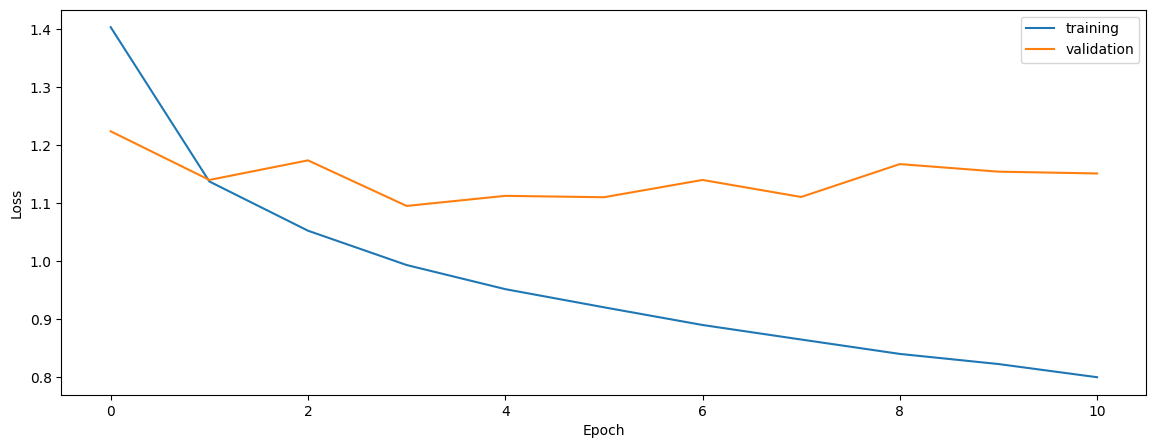

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.621556602051619
0.5705222885510903
0.5810703404424427


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native


0.510264924478862
0.49250127582293635
0.4600557025175294


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.508668901542522
0.4869640565676083
0.4636320506554581


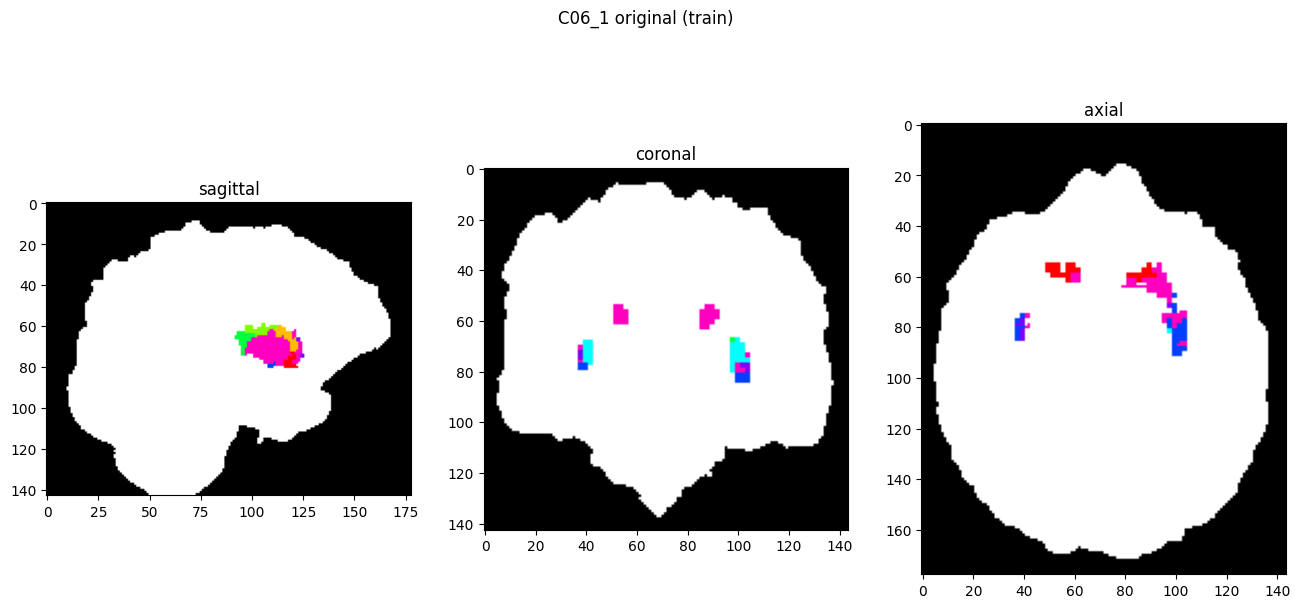

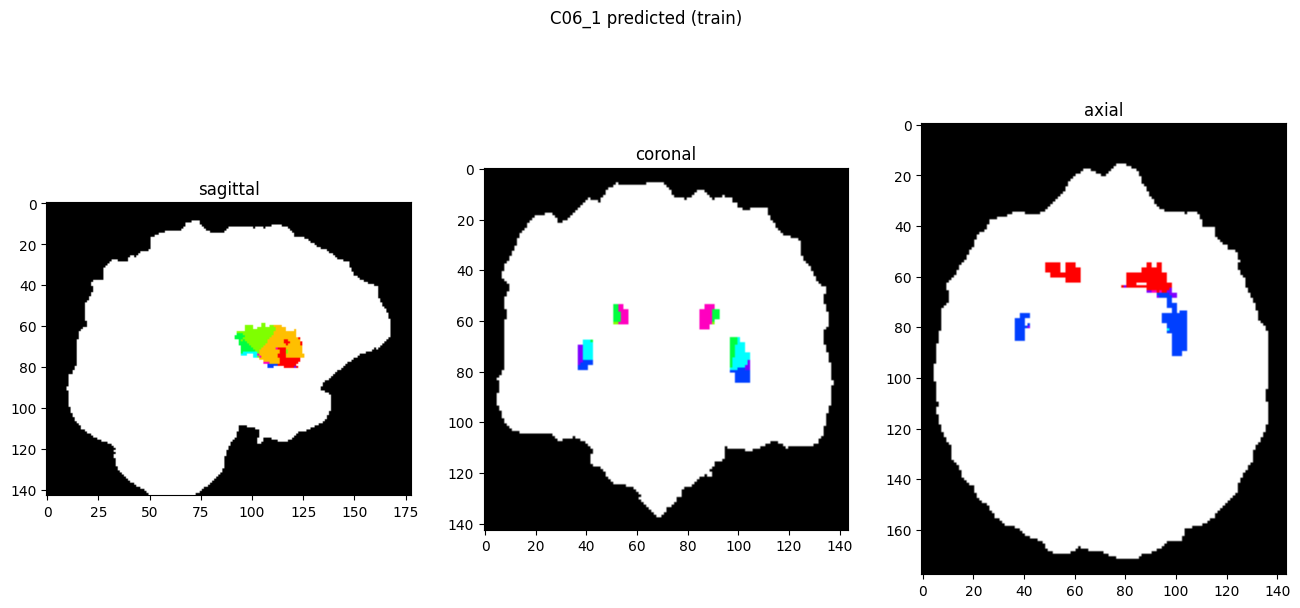

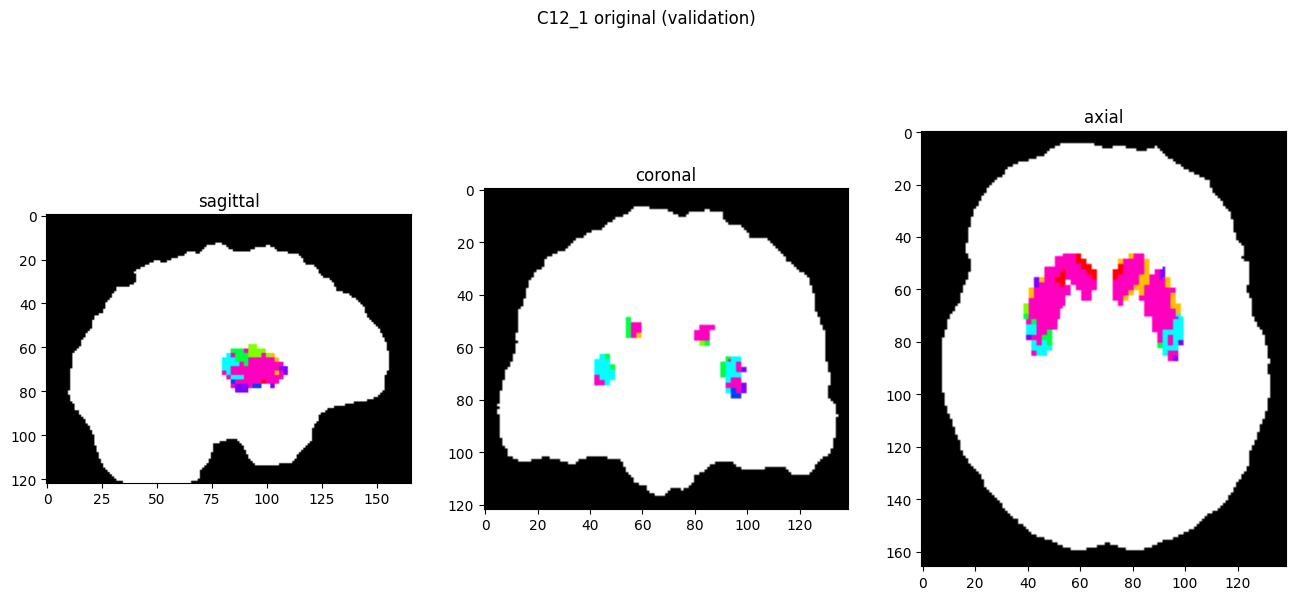

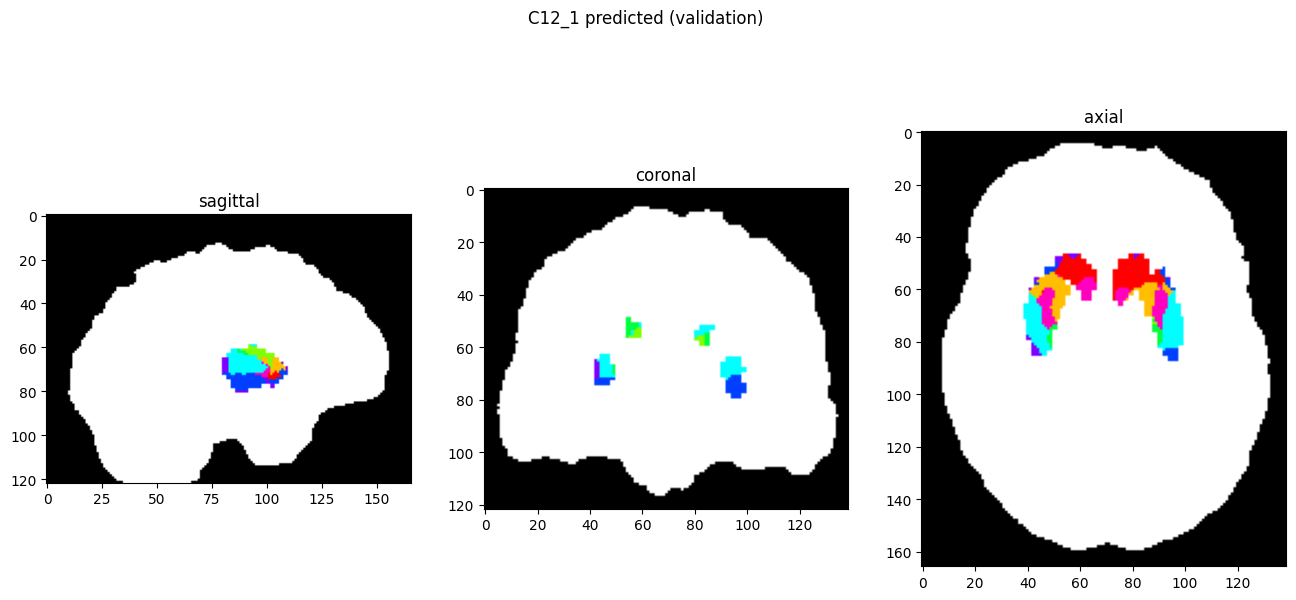

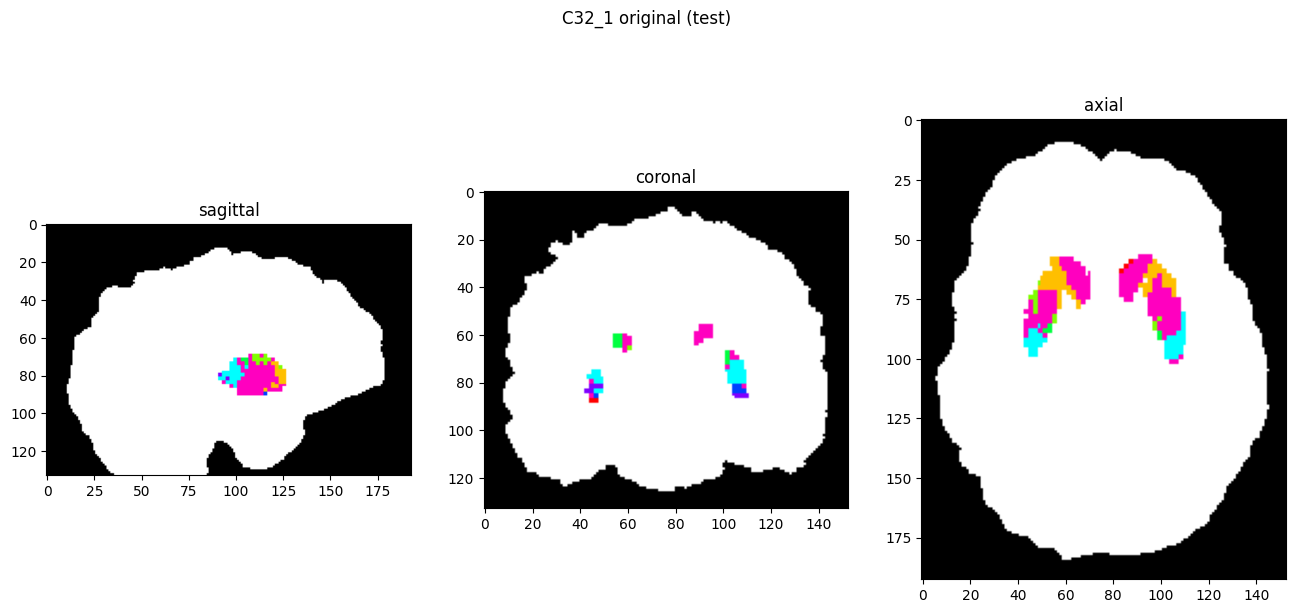

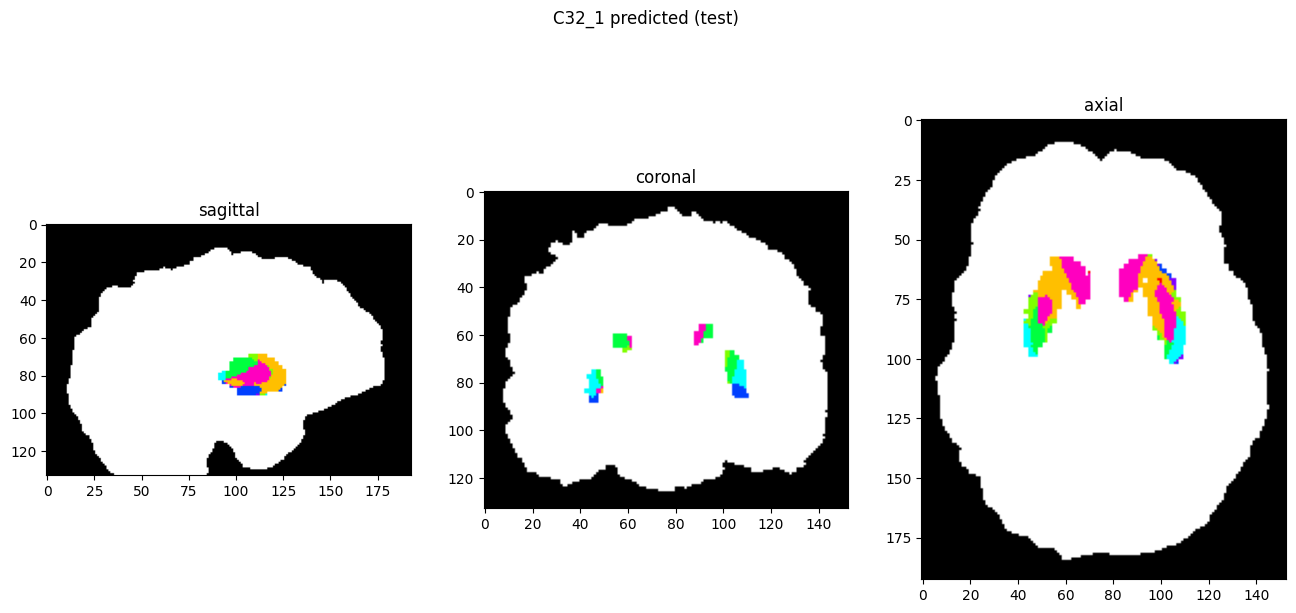

In [10]:
showResults(model, gen, threshold=0)